# Improved Question-Answering Search Engines with Transformers and Rankers

## Retrieval - Bi-Encoder

## Re-Ranker : Cross Encoder

In [1]:
!nvidia-smi

Sun Sep 15 04:20:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install Dependencies
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 10.6 MB/s eta 0:00:00


In [3]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
import numpy as np
import pandas as pd
import os
import gzip

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
# Load Wikipedia dataset - 170k articles
wikipedia_filepath = 'simplewiki-2020-11-01.jsonl.gz'

if not os.path.exists(wikipedia_filepath):
    util.http_get('http://sbert.net/datasets/simplewiki-2020-11-01.jsonl.gz', wikipedia_filepath)

passages = []

with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())

        #Add all paragraphs
        #passages.extend(data['paragraphs'])

        #Only add the first paragraph
        passages.append(data['paragraphs'][0])
print("Passages", len(passages))

  0%|          | 0.00/50.2M [00:00<?, ?B/s]

Passages 169597


In [5]:
# Subset Dataset
passages = [passage for passage in passages for x in ['india','artificial intelligence','nlp','natural language processing',
                                                      'linguistics','machine learning','animal','cheetah','jaguar',
                                                      'north pole','mathematics','organization','politics']
            if x in passage.lower()]


In [6]:
passages

['The Philosophiæ Naturalis Principia Mathematica ("Mathematical Principles of Natural Philosophy") is a trilogy, written by Isaac Newton and published on 5 July 1687. The three-book work describes physics and mathematics. It states Newton\'s laws of motion and the derivation of Kepler\'s Laws, and observations on gravity.',
 "The integumentary system is everything covering the outside of an animal's body. This account is written mostly with people in mind, but it applies more widely.",
 'The electric eel, "Electrophorus electricus", is a species of fish. It can weigh up to six pounds. It can give electric shocks of up to six hundred fifty watts of electricity. The animal uses these shocks both for hunting and to defend itself. It lives in the stagnant muddy river bottoms of the Orinoco and the Amazon, and uses low-voltage electric fields to find its prey.',
 'Sergeant is a rank used in most militaries, police forces, and other uniformed organizations around the world. The word comes f

In [7]:
len(passages)

7710

In [8]:
passages[4]

'The term Far East means countries of East Asia. It became used in the English language during the period of the British Empire for lands to the east of British India.'

In [9]:
passages[20]

'Biodiesel is a type of fuel prepared by changing vegetable oil, animal fat, special types of algae and possibly even sewage. It is considered a type of renewable energy, since it all comes from living plants and animals. It can be used to power an engine, usually for vehicles, including airplanes. It replaces diesel that comes from petroleum, a type of fossil fuel.'

# Load Transformer Models

In [10]:
if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to this notebook")

bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
corpus_embedding=bi_encoder.encode(passages)

In [12]:
passages[4]

'The term Far East means countries of East Asia. It became used in the English language during the period of the British Empire for lands to the east of British India.'

In [13]:
corpus_embedding[4]

array([ 6.45877644e-02,  4.62407582e-02,  2.69953497e-02,  1.61386933e-03,
        5.54652419e-03, -6.75918087e-02, -1.23445243e-02, -8.00438076e-02,
       -3.38172987e-02, -4.69723120e-02, -7.10594747e-03, -3.19387652e-02,
        2.32179035e-02, -8.47572344e-04,  4.86454703e-02, -3.28352712e-02,
       -4.86013256e-02, -5.53839579e-02, -1.11873165e-01, -3.03761624e-02,
        1.42082214e-01, -1.21435635e-02,  6.71664551e-02,  3.16646472e-02,
       -3.22729745e-03,  1.38958152e-02,  7.09804595e-02, -1.14700450e-02,
        4.07471955e-02,  6.47887513e-02,  3.51391733e-02,  7.54006803e-02,
        2.23483406e-02,  7.11133033e-02, -5.26615977e-02, -2.48922054e-02,
       -1.05124928e-01, -3.67301367e-02,  7.89018571e-02, -3.05165164e-02,
       -2.07163393e-02,  2.14880388e-02,  9.39267278e-02,  2.21719667e-02,
       -1.90455131e-02,  6.27500266e-02, -3.32798064e-02,  3.93606685e-02,
       -5.32850204e-03,  4.65633720e-02,  3.85220163e-02,  4.05066237e-02,
       -3.93593311e-02, -

In [14]:
corpus_embedding[4].shape

(384,)

# Try search with a Sample Query

# New Query

In [15]:
query = "What is the capital of India?"
query

'What is the capital of India?'

In [16]:
# Get embedding for new query

query_embedding = bi_encoder.encode(query)
query_embedding

array([ 1.33737773e-01,  7.78846582e-03, -7.45533481e-02,  2.49207648e-03,
       -6.24073409e-02, -4.04104292e-02,  4.16974686e-02, -2.87630446e-02,
        7.81868957e-03,  1.24428151e-02,  2.99324311e-04, -1.13784306e-01,
        5.83445579e-02, -1.51665341e-02,  1.26685910e-02, -7.13799149e-02,
        3.16478983e-02, -3.98315564e-02,  6.40153885e-02, -4.27123904e-02,
        1.77848041e-02,  4.58978191e-02,  3.55000421e-02, -4.13472503e-02,
        6.97285682e-02,  7.42683141e-03,  7.50504732e-02, -7.39466995e-02,
       -3.40940170e-02, -2.02158540e-02,  3.14713307e-02, -9.29417834e-02,
        1.01784114e-02,  7.96921626e-02, -4.39619124e-02,  3.35121304e-02,
       -2.19937717e-03,  8.76956061e-02,  1.71108305e-01, -1.03098318e-01,
        7.75600225e-03,  4.10990673e-04,  1.09546026e-02,  2.07161196e-02,
       -1.01255821e-02,  4.14889567e-02, -1.23651065e-02,  2.35349070e-02,
       -2.53974833e-02, -2.56090574e-02,  7.52400905e-02, -2.78915223e-02,
       -6.31790310e-02,  

In [ ]:
# Get cosine similarity score of document embeddings compared to new query embedding

In [17]:
cos_score = util.pytorch_cos_sim(query_embedding, corpus_embedding)[0]
cos_score

tensor([-0.0045,  0.0209, -0.0524,  ...,  0.1950, -0.1026,  0.3683])

In [19]:
# Get Most Similar Document ID
top_results = torch.topk(cos_score, k=1)
idx = top_results.indices
idx

tensor([124])

In [20]:
passages[idx]

"Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, it forms the world's 4th largest urban agglomeration. They have around 19.1 million people."

In [23]:
# Bi-Encoder + Re-Ranker cross encoder seach

hits = util.semantic_search(query_embedding, corpus_embedding, top_k=20)
hits = hits[0]
# Format data for reranker
reranker_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
reranker_inp[:3]

[['What is the capital of India?',
  "Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, it forms the world's 4th largest urban agglomeration. They have around 19.1 million people."],
 ['What is the capital of India?',
  "Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capita

In [24]:
# Ger reranker score for every similar document
reranker_scores = cross_encoder.predict(reranker_inp)
reranker_scores[:3]

array([3.861031 , 3.4595218, 2.7084024], dtype=float32)

In [25]:
hits[:3]

[{'corpus_id': 124, 'score': 0.5979241132736206},
 {'corpus_id': 1052, 'score': 0.5937108993530273},
 {'corpus_id': 6012, 'score': 0.5878057479858398}]

In [26]:
for id, hit in enumerate(hits):
  hit['reranker_scores'] = reranker_scores[id]
hits[:3]

[{'corpus_id': 124, 'score': 0.5979241132736206, 'reranker_scores': 3.861031},
 {'corpus_id': 1052,
  'score': 0.5937108993530273,
  'reranker_scores': 3.4595218},
 {'corpus_id': 6012,
  'score': 0.5878057479858398,
  'reranker_scores': 2.7084024}]

# Show the top similar docuemtn to query based on both model

In [27]:
print("Top Bi-Encoder Retrieval hit: ")
hit = sorted(hits, key=lambda x:x['score'],reverse=True)[0]
print(passages[hit['corpus_id']])

print("Top Reranker Retrieval hit: ")
hit = sorted(hits, key=lambda x:x['reranker_scores'],reverse=True)[0]
print(passages[hit['corpus_id']])

Top Bi-Encoder Retrieval hit: 
Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, it forms the world's 4th largest urban agglomeration. They have around 19.1 million people.
Top Reranker Retrieval hit: 
New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.


# Create a function to return the top similar document based on any query

In [28]:
def search(query, top_k=30):
  print("Input question:", query)
  # Bi-Encoder Retrieval
  query_embedding = bi_encoder.encode(query)
  hits = util.semantic_search(query_embedding, corpus_embedding, top_k=top_k)
  hits = hits[0]  # Get the hits for the first query

  # Re-Ranking
  # Format data for reranker
  reranker_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
  # Ger reranker score for every similar document
  reranker_scores = cross_encoder.predict(reranker_inp)

  # Combine scores
  for id, hit in enumerate(hits):
    hit['reranker_scores'] = reranker_scores[id]
  # output - bi-encoder (retrieval)
  print("Top Bi-Encoder Retrieval hit: ")
  hit = sorted(hits, key=lambda x:x['score'],reverse=True)[0]
  print(passages[hit['corpus_id']])
  # output cross-encoder (reranker)
  print("Top Reranker Retrieval hit: ")
  hit = sorted(hits, key=lambda x:x['reranker_scores'],reverse=True)[0]
  print(passages[hit['corpus_id']])

# Try out the function and ask any quesion to your bot

In [35]:
query1 = "What about Artificial Intelligence?"
query2 = "What is your openion about PM Narendera Modi?"
query3 = "Whom do you think Rahul Gandhi or Narendra Modi would be better leader for India?"
query4 ="What is your openion about Natural Language Processing?"
query5 = "What is support vector machine?"
query6 = " what is the animal which can run very fast?"

In [30]:
search(query1)

Input question: What about Artificial Intelligence?
Top Bi-Encoder Retrieval hit: 
Artificial intelligence (AI) is the ability of a computer program or a machine to think and learn. It is also a field of study which tries to make computers "smart". They work on their own without being encoded with commands. John McCarthy came up with the name "Artificial Intelligence" in 1955.
Top Reranker Retrieval hit: 
Artificial intelligence (AI) is the ability of a computer program or a machine to think and learn. It is also a field of study which tries to make computers "smart". They work on their own without being encoded with commands. John McCarthy came up with the name "Artificial Intelligence" in 1955.


In [31]:
search(query2)

Input question: What is your openion about PM Narendera Modi?
Top Bi-Encoder Retrieval hit: 
Narendra Damodardas Modi (born 17 September 1950) is an Indian politician. He is the current Prime Minister of India serving since 2014. He was the 14th Chief Minister of the state of Gujarat. Modi was elected Prime Minister of India in May 2014. He is a member of Bharatiya Janata Party.
Top Reranker Retrieval hit: 
Narendra Damodardas Modi (born 17 September 1950) is an Indian politician. He is the current Prime Minister of India serving since 2014. He was the 14th Chief Minister of the state of Gujarat. Modi was elected Prime Minister of India in May 2014. He is a member of Bharatiya Janata Party.


In [32]:
search(query3)

Input question: Whom do you think Rahul Gandhi or Narendra Modi would be better leader for India?
Top Bi-Encoder Retrieval hit: 
Rahul Gandhi is an Indian politician. His great-grandfather was Jawaharlal Nehru, who was India's first Prime-Minister. His grandmother was Indira Gandhi who was India's first woman Prime Minister. His father Rajiv Gandhi was India's youngest Prime Minister. He is the president of of the Indian National Congress. He is also the chairperson of the Indian Youth Congress and the National Students Union of India. He is a member of the Indian Parliament and represents Amethi, Uttar Pradesh in the 16th Lok Sabha.
Top Reranker Retrieval hit: 
Narendra Damodardas Modi (born 17 September 1950) is an Indian politician. He is the current Prime Minister of India serving since 2014. He was the 14th Chief Minister of the state of Gujarat. Modi was elected Prime Minister of India in May 2014. He is a member of Bharatiya Janata Party.


In [33]:
search(query4)

Input question: What is your openion about Natural Language Processing?
Top Bi-Encoder Retrieval hit: 
Natural Language Processing (NLP) is a field in Artificial Intelligence, and is also related to linguistics. On a high level, the goal of NLP is to program computers to automatically understand human languages, and also to automatically write/speak in human languages. We say "Natural Language" to mean human language, and to indicate that we are not talking about computer (programming) languages.
Top Reranker Retrieval hit: 
Natural Language Processing (NLP) is a field in Artificial Intelligence, and is also related to linguistics. On a high level, the goal of NLP is to program computers to automatically understand human languages, and also to automatically write/speak in human languages. We say "Natural Language" to mean human language, and to indicate that we are not talking about computer (programming) languages.


In [34]:
search(query5)

Input question: What is support vector machine?
Top Bi-Encoder Retrieval hit: 
In mathematics, the dot product is an operation that takes two vectors as input, and that returns a scalar number as output. The number returned is dependent on the length of both vectors, and on the angle between them. The name is derived from the centered dot "·" that is often used to designate this operation; the alternative name scalar product emphasizes the scalar (rather than vector) nature of the result.
Top Reranker Retrieval hit: 
In statistics and in machine learning, a linear predictor function is a linear function (linear combination) of a set of coefficients and explanatory variables (independent variables), whose value is used to predict the outcome of a dependent variable. Functions of this sort are standard in linear regression, where the coefficients are termed regression coefficients. However, they also occur in various types of linear classifiers (e.g. logistic regression, perceptrons, sup

In [36]:
search(query6)

Input question:  what is the animal which can run very fast?
Top Bi-Encoder Retrieval hit: 
Running is the way in which people or animals travel quickly on their feet. It is a method of travelling on land. It is different to walking in that both feet are regularly off the ground at the same time. Different terms are used to refer to running according to the speed: jogging is slow, and sprinting is running fast.
Top Reranker Retrieval hit: 
A cheetah ("Acinonyx jubatus") is a medium large cat which lives in Africa. It is the fastest land animal and can run up to 112 kilometers per hour for a short time. Most cheetahs live in the savannas of Africa. There are a few in Asia. Cheetahs are active during the day, and hunt in the early morning or late evening.


# Huggingface

In [37]:
!pip install transformers

In [38]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [1]:
import pandas as pd
from transformers import pipeline
from datasets import load_dataset

In [3]:
email = """Congratulations! You've Secured Your Spot in the Learnbay Data Science Internship Jan'24 Program! 🌟
Dear Applicant,

Congratulations!


We are thrilled to inform you that your profile has been shortlisted for the prestigious Learnbay Data Science Internship Program, January 2024. Welcome to the journey of learning, growth, and exciting opportunities!

Let's celebrate your achievement with some impressive numbers. This year, we received a staggering 20,000 applications, and you stand out as one of the top 10% who made it through our rigorous screening process. Your dedication and skills truly set you apart!

To formalize your acceptance and proceed with the onboarding process, we kindly ask you to complete your profile by filling out the following form: Form Link. If you've already submitted the form, please disregard this message. The deadline to fill the form is January 18, 2024 by 5:00 PM IST.

Important Dates to Remember:
1. Internship Offer Letters and Zoom link to join the internship will be shared via email on January 22, 2024
2. Internship Start Date is January 24, 2024
   - Timing: 6:00 PM to 7:00 PM IST

Feel free to share this exciting news with your friends and family. We look forward to welcoming you to the Learnbay community and embarking on this rewarding journey together.

Congratulations once again, and get ready for an incredible experience!

Best regards,
Learnbay Data Science Internship Team
"""

In [4]:
product_review = """I bought this product from Flipkart website.
This product is very worst and replacement policy is very bad. Even I went to their New Delhi support center.
I used this laptop only for 30 minute and suddenly it turn off and it will never turn on.
And Flipkart website does not replace this product. I should have gone for better brands like Apple or Alienware.
"""

# Classification

In [6]:
classifier = pipeline(task="text-classification")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [7]:
classifier(email)

[{'label': 'POSITIVE', 'score': 0.9997090697288513}]

In [8]:
classifier(product_review)

[{'label': 'NEGATIVE', 'score': 0.9983298182487488}]

In [9]:
moview = """Best indian movie ever.an amazing directer SS Rajamouli made a movie in 2015 with a sequel in 2017  that managed to hit theatres all over the world and also   non indians watched it and gave good reviews.all genres are well mixed -action,drama,romance a little bit of comedy makes bahubali the best.Amazing CGI  says IN YOUR FACE to other indian movies.amazing cinematography,story,makeup and BGM.
Cast-
I was impressed in everyone's acting.the magnum opus made a boost to the already popualar actors career.
PRABHAS-what should i say. he is the bahubali so there is not much to talk about him cause he is just tooooo good.
RANA DAGGUBATI-he is actually having the best perfomance.i actually felt that i liked him who is the villain  and not prabhas who is the hero.he only had few years of experience of acting after a couple of flops.but he is just amazing.He also managed to get into bollywood
TAMANNAAH-tamanaah got little screen time, but that doesn't matter. it is that she impressed me with her skills within that short screen time.a thing about tamanaah is that she usually refuses to a movie if she just stays there to look good besides the hero, being saved multiple times.in this she potrays a rebel woman who has impressive sword fight skills,who fallls in love with prabhas after she drops her mask tempting him to find her.while wooing her he finds out that devasena is his mother and many other stories about his family story

"""

In [10]:
classifier(moview)

[{'label': 'POSITIVE', 'score': 0.9994545578956604}]

In [11]:
# Summarization
summary = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [14]:
email

"Congratulations! You've Secured Your Spot in the Learnbay Data Science Internship Jan'24 Program! 🌟\nDear Applicant,\n\nCongratulations!\n\n\nWe are thrilled to inform you that your profile has been shortlisted for the prestigious Learnbay Data Science Internship Program, January 2024. Welcome to the journey of learning, growth, and exciting opportunities!\n\nLet's celebrate your achievement with some impressive numbers. This year, we received a staggering 20,000 applications, and you stand out as one of the top 10% who made it through our rigorous screening process. Your dedication and skills truly set you apart!\n\nTo formalize your acceptance and proceed with the onboarding process, we kindly ask you to complete your profile by filling out the following form: Form Link. If you've already submitted the form, please disregard this message. The deadline to fill the form is January 18, 2024 by 5:00 PM IST.\n\nImportant Dates to Remember:\n1. Internship Offer Letters and Zoom link to jo

In [12]:
summary(email)

[{'summary_text': ' The deadline to fill the form is January 18, 2024 by 5:00 PM IST . The internship offer letters and Zoom link to join the internship will be shared via email on January 22, 2024 . Internship start date is January 24, 2024 - Timing: 6:00pm to 7:00PM IST .'}]

In [15]:
product_review

'I bought this product from Flipkart website.\nThis product is very worst and replacement policy is very bad. Even I went to their New Delhi support center.\nI used this laptop only for 30 minute and suddenly it turn off and it will never turn on.\nAnd Flipkart website does not replace this product. I should have gone for better brands like Apple or Alienware.\n'

In [16]:
summary(product_review, max_length=20)

Your min_length=56 must be inferior than your max_length=20.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1282: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (20). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


[{'summary_text': ' The product is very worst and replacement policy is very bad . Flipkart website does'}]

In [17]:
moview

"Best indian movie ever.an amazing directer SS Rajamouli made a movie in 2015 with a sequel in 2017  that managed to hit theatres all over the world and also   non indians watched it and gave good reviews.all genres are well mixed -action,drama,romance a little bit of comedy makes bahubali the best.Amazing CGI  says IN YOUR FACE to other indian movies.amazing cinematography,story,makeup and BGM.\nCast-\nI was impressed in everyone's acting.the magnum opus made a boost to the already popualar actors career.\nPRABHAS-what should i say. he is the bahubali so there is not much to talk about him cause he is just tooooo good.\nRANA DAGGUBATI-he is actually having the best perfomance.i actually felt that i liked him who is the villain  and not prabhas who is the hero.he only had few years of experience of acting after a couple of flops.but he is just amazing.He also managed to get into bollywood\nTAMANNAAH-tamanaah got little screen time, but that doesn't matter. it is that she impressed me w

In [18]:
summary(moview)

[{'summary_text': ' SS Rajamouli directed a movie in 2015 with a sequel in 2017 that managed to hit theatres all over the world . The magnum opus made a boost to the already popualar actors career . All genres are well mixed -action,drama,romance a little bit of comedy makes bahubali the best .'}]

In [ ]:
# Question-Answering

In [19]:
qna=pipeline("question-answering")

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [20]:
email

"Congratulations! You've Secured Your Spot in the Learnbay Data Science Internship Jan'24 Program! 🌟\nDear Applicant,\n\nCongratulations!\n\n\nWe are thrilled to inform you that your profile has been shortlisted for the prestigious Learnbay Data Science Internship Program, January 2024. Welcome to the journey of learning, growth, and exciting opportunities!\n\nLet's celebrate your achievement with some impressive numbers. This year, we received a staggering 20,000 applications, and you stand out as one of the top 10% who made it through our rigorous screening process. Your dedication and skills truly set you apart!\n\nTo formalize your acceptance and proceed with the onboarding process, we kindly ask you to complete your profile by filling out the following form: Form Link. If you've already submitted the form, please disregard this message. The deadline to fill the form is January 18, 2024 by 5:00 PM IST.\n\nImportant Dates to Remember:\n1. Internship Offer Letters and Zoom link to jo

In [22]:
question = "when are we going to receive an offer letter?"

In [23]:
qna(question=question, context=email)

{'score': 0.4403611421585083,
 'start': 1032,
 'end': 1050,
 'answer': 'January 22, 2024\n2'}

In [24]:
amitabh = """Amitabh Bachchan (pronounced [əmɪˈt̪ɑːbʱ ˈbətːʃən] ⓘ; born Amitabh Srivastava;[1] 11 October 1942[7]) is an Indian actor who works in Hindi cinema. He is often considered one of the greatest, most accomplished and commercially successful actors in the history of Indian cinema.[8] With a cinematic career spanning over five decades, he has played pivotal roles in over 200 films. Bachchan is often hailed as the Shahenshah of Bollywood, Sadi Ke Mahanayak (translated as "Greatest actor of the century" in Hindi), Star of the Millennium, or simply Big B.[9] His dominance in the Indian film industry during the 1970s–80s led the French director François Truffaut to describe it as a "one-man industry".[10] He is a recipient of several accolades including six National Film Awards and sixteen Filmfare Awards.

Bachchan was born in 1942 in Allahabad (now Prayagraj) to the Hindi poet Harivansh Rai Bachchan and his wife, the social activist Teji Bachchan. He was educated at Sherwood College, Nainital, and Kirori Mal College, University of Delhi. His film career started in 1969 as a voice narrator in Mrinal Sen's film Bhuvan Shome. He first gained popularity in the early 1970s for films, such as Anand, Zanjeer and Roti Kapada Aur Makaan, and achieved greater stardom in later years, being dubbed India's "Angry Young Man" for several of his on-screen roles in Hindi films.[11][12] He consistently starred in top–grossing Indian films with critical acclaim from the mid-1970s to the 1980s, such as Deewaar, Sholay, Kabhi Kabhie, Hera Pheri, Amar Akbar Anthony, Parvarish, Don, Trishul, Muqaddar Ka Sikandar, Suhaag, Dostana, Naseeb, Laawaris, Namak Halaal, Andhaa Kaanoon, Coolie, Sharaabi and Mard,[13][14] as well as some of his most acclaimed performances, include Namak Haraam, Abhimaan, Majboor, Mili, Chupke Chupke, Kaala Patthar, Shaan, Silsila, Yaarana, Kaalia, Shakti, Aakhree Raasta, Shahenshah and Agneepath.[15][16] After taking a break from acting in the 1990s, his resurgence was marked in 2000 with Mohabbatein.[17] Since then he starred in several successful and acclaimed films like Kabhi Khushi Kabhie Gham, Aankhen, Baghban, Khakee, Black, Bunty Aur Babli, Sarkar, Kabhi Alvida Naa Kehna, Cheeni Kum, Paa, Bhoothnath Returns, Piku, Pink, Badla, Brahmāstra and Kalki 2898 AD.[18] For Piku, he won his fourth National Film Award for Best Actor, making him the only actor to do so. Bachchan also made an appearance in a Hollywood film, The Great Gatsby (2013), in which he played a non-Indian Jewish character.[19]

He has won numerous accolades in his career, including record four National Film Awards in Best Actor category and many awards at international film festivals and award ceremonies. He has won sixteen Filmfare Awards and is the most nominated performer in any major acting category at Filmfare with 34 nominations in Best Actor and 42 nominations overall. The Government of India honoured him with the Padma Shri in 1984, the Padma Bhushan in 2001, the Padma Vibhushan in 2015, and India's highest award in the field of cinema, the Dadasaheb Phalke Award in 2018 for his contributions to the arts. The Government of France honoured him with its highest civilian honour, Officer of the Legion of Honour, in 2007 for his exceptional career in the world of cinema and beyond.

In addition to acting, Bachchan has worked as a playback singer, film producer, and television presenter. He has hosted several seasons of the game show Kaun Banega Crorepati, India's version of the game show franchise, Who Wants to Be a Millionaire?. He also entered politics for a time in the 1980s. Bachchan has also been involved in several humanitarian works and he is a leading brand endorser in India. Beyond the Indian subcontinent, he acquired a large overseas following of the South Asian diaspora, as well as others, in markets including Africa (South Africa, Eastern Africa, and Mauritius), the Middle East (especially Egypt and the UAE), the United Kingdom, Russia, Central Asia, the Caribbean (Guyana, Suriname, and Trinidad and Tobago), Oceania (Fiji, Australia, and New Zealand), Canada and the United States.[20] Bachchan was voted the "greatest star of stage or screen" in the BBC Your Millennium online poll in 1999.[21] In October 2003, Time magazine dubbed Bachchan the "Star of the Millennium".[22]

Early life and family
Further information: Bachchan family
Bachchan was born on 11 October 1942 in Allahabad (now Prayagraj) to Hindi poet Harivansh Rai Bachchan and social activist Teji Bachchan.[23] Harivansh Rai Bachchan was an Awadhi Hindu Kayastha,[24] who was fluent in Awadhi,[25] Hindi and Urdu.[26] Harivansh's ancestors came from a village called Babupatti, in the Raniganj tehsil, in the Pratapgarh district, in the present-day state of Uttar Pradesh, in India.[27] Teji Bachchan was a Punjabi Sikh Khatri from Lyallpur, Punjab, British India (present-day Faisalabad, Punjab, Pakistan).[25][28] Bachchan has a younger brother, Ajitabh, who is five years younger than him.[29]

Bachchan's parents were initially going to name him Inquilaab (Hindustani for "Revolution"), inspired by the phrase Inquilab Zindabad (which translates into English as "Long live the revolution") popularly used during the Indian independence struggle; the name Amitabh was suggested to his father by poet Sumitranandan Pant.[30][1] Although his surname was Shrivastava, Amitabh's father, who opposed the caste system, had adopted the pen name Bachchan ("child-like" in colloquial Hindi), under which he published all of his works.[31] When his father was looking to get him admitted to a school, he and Bachchan's mother decided the family's name should be Bachchan instead of Shrivastava.[32] It is with this last name that Amitabh debuted in films and used for all other practical purposes, Bachchan has become the surname for all of his immediate family.[33] Bachchan's father died in 2003, and his mother in 2007.[34]

Bachchan's secondary education was at Boys' High School & College in Allahabad and Sherwood College in Nainital. He attended Kirori Mal College at the University of Delhi in Delhi.[35][36] He graduated with a Bachelor of Science degree from Kirori Mal College in 1962.[37][38][39] When Bachchan finished his studies, his father approached Prithviraj Kapoor, the founder of Prithvi Theatre and patriarch of the Kapoor acting family, to see if there was an opening for him, but Kapoor offered no encouragement.[40] Bachchan was a friend of Rajiv Gandhi and Sanjay Gandhi, before he became an actor. He used to spend time with them when he was a resident in New Delhi. Bachchan's family were very close to the Nehru-Gandhi family of politicians. When Sonia Gandhi first came to India from Italy before her marriage, Bachchan had received her at the Palam International Airport on 13 January 1968. She spent 48 days at Bachchan's house with his parents before her wedding to Rajiv.[41]

In the late 1960s, Bachchan applied to be a newsreader for All India Radio in Delhi, but "failed the audition".[40][42] He became a business executive for Bird & Company in Kolkata (Calcutta),[40] [when?] and worked in theatre before starting his film career.[43] It is thought that his mother might have had some influence on his choice of career, for she always insisted that he should "take centre stage".[44][according to whom?]

Acting career
Further information: Amitabh Bachchan filmography
Early career (1969–1972)
Bachchan made his film debut in 1969, as a voice narrator in Mrinal Sen's National Award–winning film Bhuvan Shome.[45] His first acting role was as one of the seven protagonists in the film Saat Hindustani,[46] directed by Khwaja Ahmad Abbas and featuring Utpal Dutt, Anwar Ali (brother of comedian Mehmood), Madhu and Jalal Agha.[47][48] Anand (1971) followed, in which Bachchan starred alongside Rajesh Khanna. His role as a doctor with a cynical view of life garnered Bachchan his first Filmfare Award for Best Supporting Actor. He then played his first antagonist role as an infatuated lover-turned-murderer in Parwana (1971). Following Parwana were several films, including Reshma Aur Shera (1971). During this time, he made a guest appearance in the film Guddi which starred his future wife Jaya Bhaduri. He narrated part of the film Bawarchi.[49] In 1972, he made an appearance in the road action comedy Bombay to Goa directed by S. Ramanathan which was moderately successful.[50] Many of Bachchan's films during this early period did not do well.[51] His only film with Mala Sinha, Sanjog (1972) was also a box office failure.[52]

Rise to prominence (1973–1974)
Bachchan was struggling, seen as a "failed newcomer" who, by the age of 30, had twelve flops and only two successes (as a lead in Bombay to Goa and a supporting role in Anand). He was offered to play dual roles by director O. P. Goyle and writer O. P. Ralhan for the film Bandhe Haath in 1973. This was the first movie in which Bachchan played a double role.[53] Bachchan was then discovered by screenwriter duo Salim–Javed, consisting of Salim Khan and Javed Akhtar.[54] Salim Khan wrote the story, screenplay and script of Zanjeer (1973), and conceived the "angry young man" persona of the lead role. Javed Akhtar came on board as co-writer,[55] and Prakash Mehra, who saw the script as potentially groundbreaking, as the film's director. However, they were struggling to find an actor for the lead "angry young man" role; it was turned down by several actors, owing to it going against the "romantic hero" image dominant in the industry at the time.[54] Salim-Javed "saw his talent, which most makers didn't. He was exceptional, a genius actor who was in films that weren't good."[56] According to Salim Khan, they "strongly felt that Amitabh was the ideal casting for Zanjeer".[54] Salim Khan introduced Bachchan to Prakash Mehra,[55] and Salim-Javed insisted that Bachchan be cast for the role.[54]

Zanjeer was a crime film with violent action,[54] in sharp contrast to the romantically themed films that had generally preceded it, and it established Amitabh in a new persona—the "angry young man" of Bollywood.[57] He earned his first Filmfare Award nomination for Best Actor, with Filmfare later considering this one of the most iconic performances in Bollywood history.[51] The film was a huge success and one of the highest-grossing films of that year, breaking Bachchan's dry spell at the box office and making him a star.[58] It was the first of many collaborations between Salim-Javed and Amitabh; the duo wrote many of their subsequent scripts with Bachchan in mind for the lead role, and insisted on him being cast for their later films, including blockbusters such as Deewaar (1975) and Sholay (1975).[56] Salim Khan also introduced Bachchan to director Manmohan Desai with whom he formed a long and successful association, alongside Prakash Mehra and Yash Chopra.[55]

Eventually, Bachchan became one of the most successful leading men of the film industry. His portrayal of the wronged hero fighting a crooked system and circumstances of deprivation in films like Zanjeer, Deewaar, Trishul, Kaala Patthar and Shakti resonated with the masses of the time, especially the youth who harboured a simmering discontent owing to social ills such as poverty, hunger, unemployment, corruption, social inequality and the brutal excesses of The Emergency. This led to Bachchan being dubbed as the "angry young man", a journalistic catchphrase that became a metaphor for the dormant rage, frustration, restlessness, sense of rebellion and anti-establishment disposition of an entire generation, prevalent in 1970s India.[59][60][61]

The year 1973 was also when he married Jaya, and around this time they appeared in several films together: not only Zanjeer but also subsequent films such as Abhimaan, which was released only a month after their wedding and was also successful at the box office. Later, Bachchan played the role of Vikram, once again along with Rajesh Khanna, in the film Namak Haraam, a social drama directed by Hrishikesh Mukherjee and scripted by Biresh Chatterjee addressing themes of friendship.[62] His supporting role won him his second Filmfare Award for Best Supporting Actor.[63]

The flow of successes continued for Bachchan in 1974.[64] He began the year with a guest appearance in Dulal Guha's blockbuster social drama film Dost.[65] After this, he starred in Aravind Sen's drama film Kasauti and Narendra Bedi's crime thriller Benaam, both of which ended up as moderate commercial successes. Bachchan's next release was Manoj Kumar's fourth directional venture Roti Kapada Aur Makaan.[66] The film opened to excellent response all over the country, eventually taking top spot at the box office that year and emerging an All Time Blockbuster as well as Bachchan's biggest hit at that point of time.[67] Before the end of year, he delivered a hit in Ravi Tandon's crime thriller Majboor.[68][69] Written by Salim-Javed, it also had Pran and Parveen Babi in the lead.[70]

Superstardom (1975–1988)
In 1975, he starred in a variety of film genres, from the comedy Chupke Chupke and the crime drama Faraar to the romantic drama Mili.[71] This was also the year in which Bachchan starred in two films regarded as important in Hindi cinema history, both written by Salim-Javed, who again insisted on casting Bachchan.[56] The first was Deewaar, directed by Yash Chopra, where he worked with Shashi Kapoor, Nirupa Roy, Parveen Babi, and Neetu Singh. The film emerged a huge blockbuster at the box office and earned him another Filmfare nomination for Best Actor.[72] Indiatimes ranks Deewaar among the Top 25 Must See Bollywood Films.[73] The other, released on 15 August 1975, was Sholay, which became the highest-grossing film ever in India at the time,[74] in which Bachchan played the role of Jaidev. Deewaar and Sholay are often credited with exalting Bachchan to the heights of superstardom, two years after he became a star with Zanjeer, and consolidating his domination of the industry throughout the 1970s and 1980s.[75][76] In 1999, BBC India declared Sholay the "Film of the Millennium" and, like Deewaar, it has been cited by Indiatimes Movies as among the Top 25 Must See Bollywood Films.[73] In that same year, the judges of the 50th annual Filmfare Awards awarded it with the special distinction award called the Filmfare Best Film of 50 Years.


Bachchan and Dharmendra starrer Sholay (1975) recorded an estimated ₹15-18 crore footfalls, making it the highest grossing Indian film in terms of audience attendance to date.[77]
In 1976, he was cast by Yash Chopra in the romantic musical Kabhi Kabhie.[78] Bachchan starred as a young poet, Amit Malhotra, who falls deeply in love with a beautiful young girl named Pooja (Rakhee Gulzar) who ends up marrying someone else (Shashi Kapoor). The film was notable for portraying Bachchan as a romantic hero, a far cry from his "angry young man" roles like Zanjeer and Deewaar. Despite its heavy theme, Kabhi Kabhie went on to become a superhit.[79] Its soundtrack composed by Khayyam dominated the musical charts and was one of the best selling Hindi film albums of the 1970s.[80] Bachchan was again nominated for the Filmfare Best Actor Award for his role in the film. That same year, he played a double role in another major hit Adalat as father and son. In 1977, he won his first Filmfare Best Actor Award for his performance in Amar Akbar Anthony, in which he played the third lead opposite Vinod Khanna and Rishi Kapoor as Anthony Gonsalves. The film was the highest-grossing film of that year. His other major hits that year include Parvarish and Khoon Pasina.[81][82]

He once again resumed double roles in films such as Kasme Vaade (1978) as Amit and Shankar and Don (1978) playing the characters of Don, a leader of an underworld gang and his look-alike Vijay. His performance won him his second Filmfare Best Actor Award. He also gave towering performances in Yash Chopra's Trishul and Prakash Mehra's Muqaddar Ka Sikandar both of which earned him further Filmfare Best Actor nominations. 1978 is arguably considered his most successful year at the box office since all of his six releases in the same year, namely Muqaddar Ka Sikandar, Trishul, Don, Kasme Vaade, Ganga Ki Saugandh and Besharam were box office successes, with the former three being the consecutive highest-grossing films of the year, a rare feat in Hindi cinema.[83][84]

In 1979, Bachchan starred in Suhaag which was the highest-earning film of that year.[85] In the same year, he also enjoyed critical acclaim and commercial success with films like Mr. Natwarlal and Kaala Patthar.[86] He was required to use his singing voice for the first time in a song from the film Mr. Natwarlal in which he starred with Rekha. Bachchan's performance in the film saw him nominated for both the Filmfare Award for Best Actor and the Filmfare Award for Best Male Playback Singer. He also received a Best Actor nomination for Kaala Patthar and then went on to be nominated again in 1980 for the Raj Khosla directed superhit film Dostana, in which he starred opposite Shatrughan Sinha and Zeenat Aman.[87] In 1981, he starred in Yash Chopra's melodrama film Silsila, where he starred alongside his wife Jaya Bachchan and also Rekha.[88] Other successful films of this period include Ram Balram (1980), Shaan (1980), Naseeb (1981), Lawaaris (1981), Kaalia (1981), Yaarana (1981), Barsaat Ki Ek Raat (1981) and Shakti (1982), also starring Dilip Kumar.[89][90]

In 1982, he played double roles in the musical Satte Pe Satta and action drama Desh Premee which succeeded at the box office along with mega hits like action comedy Namak Halaal, action drama Khud-Daar and the critically acclaimed drama Bemisal.[91] On 26 July 1982, while filming a fight scene with co-actor Puneet Issar for Coolie, Bachchan had a near-fatal intestinal injury.[92] Bachchan was performing his stunts in the film and one scene required him to fall onto a table and then on the ground. However, as he jumped towards the table, the corner of the table struck his abdomen, resulting in a splenic rupture from which he lost a significant amount of blood. He required an emergency splenectomy and remained critically ill in the hospital for many months, at times close to death. There were long queues of well-wishing fans outside the hospital where he was recuperating; the public response included prayers in places of worship and offers to sacrifice limbs to save him.[93] Nevertheless, he resumed filming later that year after a long period of recuperation. The director, Manmohan Desai, altered the ending of Coolie: Bachchan's character was originally intended to have been killed off; but, after the change of script, the character lived in the end. Desai felt it would have been inappropriate for the man who had just fended off death in real life to be killed on screen. The footage of the fight scene is frozen at the critical moment, and a caption appears onscreen marking it as the instant of the actor's injury.[94] The film was released in 1983, and partly due to the huge publicity of Bachchan's accident, the film went on to become a huge blockbuster and top-grossing film of the year.[95] He then played a triple role in Mahaan which underperformed at the box office.[96] Other releases during that year included Nastik and Pukar which too didnt do that well, but Andhaa Kaanoon (in which he had an extended cameo appearance) was a blockbuster.[97] During a stint in politics from 1984 to 1987, four of his completed films were released, out of which, Sharaabi (1984) and Mard (1985) emerged blockbusters while Geraftaar (1985) and Aakhree Raasta (1986) proved to be hits.[98][69] After a three-year stint in politics from 1984 to 1987, Bachchan returned to films in 1988, playing the title role in Tinnu Anand's vigilante action film Shahenshah, which opened to bumper response all over the nation and emerged a major hit as well as the 2nd highest grossing film of the year.[99][100]

Health issues
He was later diagnosed with Myasthenia gravis. The illness weakened him both mentally and physically. At this time he became pessimistic, expressing concern with how a new film would be received, and stating before every release, "Yeh film to flop hogi!" ("This film will flop").[101] He then decided to quit films and ventured into politics.

Career fluctuations, sabbatical, business ventures and acting comeback (1989–1999)
After the success of his comeback film however, Bachchan's star power began to wane as all of his subsequent films like Jaadugar, Toofan and Main Azaad Hoon (all released in 1989) failed at the box office.[102][103][104] He gained success during this period with K.C. Bokadia and Mukul Anand's actioners Aaj Ka Arjun (1990) and Hum (1991), respectively, but this momentum was short-lived and his string of box office flops continued.[69] Notably, despite a decline in number of hits, it was during this era that Bachchan won his first National Film Award for Best Actor for his performance as a Mafia don in the cult film Agneepath (1990).[105] These years would see his last on-screen appearances for some time. After the release of the critically acclaimed epic Khuda Gawah in 1992, Bachchan went into semi-retirement for five years. Except for the much delayed Insaniyat (1994) alongside Sunny Deol, which was highly anticipated and received the biggest opening of the year but turned out to be a box office failure due to negative reception, Bachchan did not appear in any new releases for five years.[106][107]

He turned producer during his temporary retirement period, setting up Amitabh Bachchan Corporation, Ltd. (ABCL) in 1996. ABCL's strategy was to introduce products and services covering an entire cross-section of India's entertainment industry. ABCL's operations were mainstream commercial film production and distribution, audio cassettes and video discs, production and marketing of television software, and celebrity and event management.[108] Soon after the company was launched in 1996, the first film it produced was Tere Mere Sapne, which was a box office hit[109] and launched the careers of actors like Arshad Warsi and southern film star Simran.[110]

In 1997, Bachchan attempted to make his acting comeback with the film Mrityudata, produced by ABCL. Though Mrityudaata attempted to reprise Bachchan's earlier success as an action hero, the film was a failure both financially and critically.[111] ABCL was the main sponsor of the 1996 Miss World beauty pageant, Bangalore, but lost millions. The fiasco and the consequent legal battles surrounding ABCL and various entities after the event, coupled with the fact that ABCL was reported to have overpaid most of its top-level managers, eventually led to its financial and operational collapse in 1997.[112][113] The company went into administration and was later declared a failed company by the Indian Industries board. The Bombay High Court, in April 1999, restrained Bachchan from selling off his Bombay bungalow 'Prateeksha' and two flats until the pending loan recovery cases of Canara Bank were disposed of. Bachchan had, however, pleaded that he had mortgaged his bungalow to raise funds for his company.[114]

Bachchan attempted to revive his acting career, and eventually had commercial success with Bade Miyan Chote Miyan (1998) and Major Saab (1998), and received positive reviews for Sooryavansham (1999), but other films such as Lal Baadshah (1999) and Kohram (1999) were box office failures.[115][116][117][118]

Return to success (2000–present)
In 2000, Bachchan appeared in Aditya Chopra's romantic blockbuster Mohabbatein.[119] He played a stern, elder figure who rivalled the character of Shahrukh Khan.[120] His role won him his third Filmfare Award for Best Supporting Actor.[121] Other hits followed, with Bachchan appearing as an older family patriarch in Ek Rishtaa: The Bond of Love (2001), Kabhi Khushi Kabhie Gham... (2001) and Baghban (2003). As an actor, he continued to perform in a range of characters, receiving critical praise for his performances in Aks (2001), Aankhen (2002), Kaante (2002), Khakee (2004), Dev (2004) and Veer-Zaara (2004). His performance in Aks won him his first Filmfare Critics Award for Best Actor.[122]

One project that did particularly well for Bachchan was Sanjay Leela Bhansali's Black (2005). The film starred Bachchan as an ageing teacher of a deaf-blind girl and followed their relationship. His performance was unanimously praised by critics and audiences and won him his second National Film Award for Best Actor, his fourth Filmfare Best Actor Award, and his second Filmfare Critics Award for Best Actor. Taking advantage of this resurgence, Amitabh began endorsing a variety of products and services, appearing in many television and billboard advertisements. In 2005 and 2006, he starred with his son Abhishek in the films Bunty Aur Babli (2005), the Godfather adaptation Sarkar (2005), and Kabhi Alvida Naa Kehna (2006). All of them were successful at the box office.[123][124][125] His later releases in 2006 and early 2007 were Baabul (2006),[126] Ekalavya (2007) and Nishabd (2007), which failed to do well at the box office but his performances in each of them were praised by critics.[127]

In May 2007, two of his films, the romantic comedy Cheeni Kum and the multi-starrer action drama Shootout at Lokhandwala, were released. Shootout at Lokhandwala did well at the box office and was declared a hit in India, while Cheeni Kum picked up after a slow start and was declared a semi-hit by the end of its theatrical run.[128][129][130][131] A remake of his biggest hit, Sholay (1975), entitled Ram Gopal Varma Ki Aag, released in August of that same year and proved to be a major commercial failure in addition to its poor critical reception.[131] The year also marked Bachchan's first appearance in an English-language film, Rituparno Ghosh's The Last Lear, co-starring Arjun Rampal and Preity Zinta. The film premiered at the 2007 Toronto International Film Festival on 9 September 2007. He received positive reviews from critics who hailed his performance as his best since Black.[132] Bachchan was slated to play a supporting role in his first international film, Shantaram, directed by Mira Nair and starring Hollywood actor Johnny Depp in the lead. The film was due to begin filming in February 2008 but due to the writer's strike, was pushed to September 2008.[133] The film is currently "shelved" indefinitely.[134]


Amitabh Bachchan and Yash Chopra in the premiere of Paa. Bachchan received his third National Film Award for Best Actor at the 57th National Film Awards for his performance and his fifth Filmfare Award for Best Actor for Paa.
Vivek Sharma's Bhoothnath, in which he plays the title role as a ghost, was released on 9 May 2008. Sarkar Raj, the sequel of the 2005 film Sarkar, released in June 2008 and received a positive response at the box office. Paa, which was released at the end of 2009 was a highly anticipated project as it saw him playing his own son Abhishek's Progeria-affected 13-year-old son, and it opened to favourable reviews, particularly towards Bachchan's performance and was one of the top-grossing films of 2009.[135] It won him his third National Film Award for Best Actor and fifth Filmfare Best Actor Award. In 2010, he debuted in Malayalam film through Kandahar, directed by Major Ravi and co-starring Mohanlal.[136] The film was based on the hijacking incident of the Indian Airlines Flight 814.[137] Bachchan declined any remuneration for this film.[138] In 2011 he played an aged retired former gangster in Bbuddah... Hoga Terra Baap who protects his son Sonu Sood who is an honest daring police officer from a notorious gangster Prakash Raj who unknowingly hired the latter to perform a contract killing not knowing that the police officer is the gangster's son.[139] Despite huge expectations, it flopped at the box office.[140]


Bachchan with Mohanlal
In 2013, he made his Hollywood debut in The Great Gatsby making a special appearance opposite Leonardo DiCaprio and Tobey Maguire.[141] In 2014, he played the role of the friendly ghost in the sequel Bhoothnath Returns. The next year, he played the role of a grumpy father experiencing chronic constipation in the critically acclaimed Piku which was also one of the biggest hits of 2015.[142][143][144] A review in Daily News and Analysis (DNA) summarised Bachchan's performance as "The heart and soul of Piku clearly belong to Amitabh Bachchan who is in his elements. His performance in Piku, without doubt, finds a place among the top 10 in his illustrious career."[145] Rachel Saltz wrote for The New York Times, "Piku", an offbeat Hindi comedy, would have you contemplate the intestines and mortality of one Bhashkor Banerji and the actor who plays him, Amitabh Bachchan. Bhashkor's life and conversation may revolve around his constipation and fussy hypochondria, but there's no mistaking the scene-stealing energy that Mr. Bachchan, India's erstwhile Angry Young Man, musters for his new role of Cranky Old Man."[146] Well known Indian critic Rajeev Masand wrote on his website, "Bachchan is pretty terrific as Bhashkor, who reminds you of that oddball uncle that you nevertheless have a soft spot for. He bickers with the maids, harrows his hapless helper, and expects Piku to stay unmarried so she can attend to him. At one point, to ward off a possible suitor, he casually mentions that his daughter isn't a virgin; that she's financially independent and sexually independent too. Bachchan embraces the character's many idiosyncrasies, never once slipping into caricature while all along delivering big laughs thanks to his spot-on comic timing."[147] The Guardian summed up, "Bachchan seizes upon his cranky character part, making Bashkor as garrulously funny in his theories on caste and marriage as his system is backed-up."[148] The performance won Bachchan his fourth National Film Award for Best Actor and his third Filmfare Critics Award for Best Actor.


Bachchan with Vijay
In 2016, he appeared in the women-centric courtroom drama film Pink which was highly praised by critics and with an increasingly good word of mouth, was a resounding success at the domestic and overseas box office.[149][150][151][152] Bachchan's performance in the film received acclaim. According to Raja Sen of Rediff.com, "Amitabh Bachchan, a retired lawyer with bipolar disorder, takes up cudgels on behalf of the girls, delivering courtroom blows with pugilistic grace. As we know from Prakash Mehra movies, in each life some Bachchan must fall. The girls hang on to him with incredulous desperation, and he bats for them with all he has. At one point Meenal hangs by Bachchan's elbow, words entirely unnecessary. Bachchan towers through Pink – the way he bellows "et cetera" is alone worth having the heavy-hitter at play—but there are softer moments like one where he appears to have dozed off in court, or where he lays his head by his convalescent wife's bedside and needs his hair ruffled and his conviction validated."[153] Writing for Hindustan Times, noted film critic and author Anupama Chopra said of Bachchan's performance, "A special salute to Amitabh Bachchan, who imbues his character with a tragic majesty. Bachchan towers in every sense, but without a hint of showboating.[150] Meena Iyer of The Times of India wrote, "The performances are pitch-perfect with Bachchan leading the way.[154] Writing for NDTV, Troy Ribeiro of Indo-Asian News Service (IANS) stated, "Amitabh Bachchan as Deepak Sehgall, the aged defence lawyer, shines as always, in a restrained, but powerful performance. His histrionics come primarily in the form of his well-modulated baritone, conveying his emotions and of course, from the well-written lines."[155] Mike McCahill of The Guardian remarked, "Among an electric ensemble, Taapsee Pannu, Kirti Kulhari and Andrea Tariang give unwavering voice to the girls' struggles; Amitabh Bachchan brings his moral authority to bear as their sole legal ally.[156]

In 2017, he appeared in the third instalment of the Sarkar film series: Ram Gopal Varma's Sarkar 3. That year, he started filming for the swashbuckling action-adventure film Thugs of Hindostan with Aamir Khan, Katrina Kaif and Fatima Sana Shaikh which released in November 2018.[157] He co-starred with Rishi Kapoor in 102 Not Out, a comedy drama film directed by Umesh Shukla based on a Gujarati play of the same name written by Saumya Joshi.[158][159] This film released in May 2018 and reunited him with Kapoor onscreen after a gap of 27 years.[160]

In 2019, Bachchan appeared in Sujoy Ghosh's mystery thriller Badla.[161] The film did a lifetime business of ₹1.38 billion (equivalent to ₹1.7 billion or US$21 million in 2023) worldwide to emerge a box office hit.[162] The following year, he co-starred alongside Ayushmann Khurana in Shoojit Sircar's comedy drama Gulabo Sitabo, which opened to critical acclaim & won him Filmfare Award for Best Actor (Critics).[163] He then collaborated with Emraan Hashmi for Chehre (2021), which was a critical and commercial failure.[164]

The next year, Bachchan had five releases, out of which Ayan Mukerji's highly anticipated fantasy action-adventure film Brahmāstra: Part One – Shiva proved to be a hit as well as the highest-grossing Hindi film of 2022 while Jhund, Runway 34 and Uunchai didn't do well at ticket counters, but met with positive response from critics.[165][166][167] In 2024, he played Ashwatthama in Nag Ashwin's Kalki 2898 AD, marking his Telugu debut.[168][169][170]

Other works

Bachchan at KBC-5 Press Meet
Television appearances
In 2000, Bachchan hosted the first season of Kaun Banega Crorepati (KBC), the Indian adaptation of the British television game show, Who Wants to Be a Millionaire?. The show was well received.[171] A second season followed in 2005 but its run was cut short by Star Plus when Bachchan fell ill in 2006.[172] He then returned to host the fourth season, and has hosted the show since.[173]

In 2009, Bachchan hosted the third season of the reality show Bigg Boss.[174]

In 2010, Bachchan hosted the fourth season of KBC.[175] The fifth season started on 15 August 2011 and ended on 17 November 2011. The show became a massive hit with audiences and broke many TRP Records. CNN IBN awarded Indian of the Year- Entertainment to Team KBC and Bachchan. The Show also grabbed all the major Awards for its category.[176]

The sixth season was also hosted by Bachchan, commencing on 7 September 2012, broadcast on Sony TV and received the highest number of viewers thus far.[citation needed]

In 2014, he debuted in the fictional Sony Entertainment Television TV series titled Yudh playing the lead role of a businessman battling in both his personal and professional lives.[177]

Voice acting
Bachchan is known for his deep, baritone voice. He has been a narrator, a playback singer, and a presenter for numerous programmes.[178] Some prominent films featuring his narration are Satyajit Ray's 1977 film Shatranj Ke Khiladi[179] and Ashutosh Gowarikar's 2001 film Lagaan.[180]

He also has done voice-over work for the following movies:[181][182][183]

Bhuvan Shome (1969)[184]
Bawarchi (1972)[185]
Balika Badhu (1975)[185]
Tere Mere Sapne (1996)[185]
Hello Brother (1999)[citation needed]
Lagaan (2001)
Fun2shh... Dudes in the 10th Century (2003)
Parineeta (2005)[185]
March of the Penguins (2005), Indian version[186]
Swami (2007)[185]
Jodhaa Akbar (2008)
Zor Lagaa Ke...Haiya! (2009)
Ra.One (2011)
Kahaani (2012)
Krrish 3 (2013)
Mahabharat (2013)[187]
Kochadaiiyaan (Hindi Version) (2014)
CBI documentary (2014) – sanctioned by Central Bureau of Investigation[188]
The Ghazi Attack (2017)
Firangi (2017)
Business investments
Around 1994, Bachchan started Amitabh Bachchan Corporation Ltd (ABCL), an event management, production and distribution company. But the company fell into debt with a fiasco and went into bankruptcy, subsequently Bachchan became nearly bankrupt. The reasons for this debacle were flop films such as Mrityudata, Major Saab (produced by this organisation), and Miss World 1996 which was organised-managed by ABCL. Due to this he began work for TV, and asked for work to Yash Chopra. Once he said that 'it was the darkest time for him'.[189][190]

He has invested in many upcoming business ventures. In 2013, he bought a 10% stake in Just Dial from which he made a gain of 4600 per cent. He holds a 3.4% equity in Stampede Capital, a financial technology firm specialising in cloud computing for financial markets. The Bachchan family also bought shares worth $252,000 in Meridian Tech, a consulting company in the U.S. Recently they made their first overseas investment in Ziddu.com, a cloud-based content distribution platform.[191][192] Bachchan was named in the Panama Papers and Paradise Papers, leaked confidential documents relating to offshore investment.[193][194]

Political career
In 1984, Bachchan took a break from acting and briefly entered politics in support of a long-time family friend, Rajiv Gandhi. He contested the Allahabad's (presently Prayagraj Lok Sabha constituency) seat for the 8th Lok Sabha against H. N. Bahuguna, former Chief Minister of Uttar Pradesh. With 68.2% of the votes in his favour, he won by one of the highest victory margins ever in Indian elections.[195] In 1987, Indian Express said his brother Ajitabh Bachchan owned an apartment in Switzerland, giving rise to speculations about his involvement in the "Bofors scandal", revealed in the year before.[196] Bachchan resigned from his seat in July 1987.[why?][197] Ajitabh Bachchan sued Swedish newspaper Dagens Nyheter for linking him to Bofors payments in 1990 and won damages in the United Kingdom.[198] Sten Lindstrom, the Swedish police chief who had investigated the case, said in 2012 that "Indian investigators planted the Bachchan angle on" Dagens Nyheter.[199][why?]

Bachchan's old friend, Amar Singh, helped him during the financial crisis caused by the failure of his company, ABCL. Thereafter Bachchan started supporting the Samajwadi Party, the political party to which Amar Singh belonged. Jaya Bachchan joined the Samajwadi Party and represented the party as an MP in the Rajya Sabha.[200] Bachchan appeared in advertisements and political campaigns for the party. His claim that he too was a farmer in the advertisements was questioned in court.[201]

Bachchan has claimed to have been banned by film press during the emergency years for his family's friendship with Indira Gandhi.[202]

Bachchan has been accused of using the slogan "blood for blood" in the context of the 1984 anti-Sikh riots. Bachchan has denied the allegation.[203] In October 2014, Bachchan was summoned by a court in Los Angeles for "allegedly instigating violence against the Sikh community".[204] Bachchan in an interview with journalist Arnab Goswami offered to fight the case in court and asked the accusers to file the same as also present proof.[205] He was also one of the trustees of the Rajiv Gandhi Foundation.[206][207]

Humanitarian and social causes
Bachchan has been involved with many social causes. For example, he donated ₹1.1 million to clear the debts of nearly 40 beleaguered farmers in Andhra Pradesh[208] and ₹3 million to clear the debts of some 100 Vidarbha farmers.[209] In 2010, he donated ₹1.1 million to Resul Pookutty's foundation for a medical centre at Kochi,[210][211][212] and he has given ₹250,000 ($4,678) to the family of Delhi policeman Subhash Chand Tomar who died after succumbing to injuries during a protest against gang-rape after the 2012 Delhi gang rape case.[213] He founded the Harivansh Rai Bachchan Memorial Trust, named after his father, in 2013. This trust, in association with Urja Foundation, will be powering 3,000 homes in India with electricity through solar energy.[214][215] In June 2019 he cleared debts of 2100 farmers from Bihar.[216]


TeachAids character of Bachchan (left); Bachchan in a 2013 TeachAids recording session (right)
Bachchan was made a UNICEF Goodwill Ambassador for the polio eradication campaign in India in 2002 and an international ambassador in 2005 and a WHO Goodwill Ambassador for awareness of hepatitis in 2017.[217][218][219] In 2013, he and his family donated ₹2.5 million ($42,664) to a charitable trust, Plan India, that works for the betterment of young girls in India.[220] He also donated ₹1.1 million ($18,772) to the Maharashtra Police Welfare Fund in 2013.[221]

Bachchan was the face of the 'Save Our Tigers' campaign that promoted the importance of tiger conservation in India.[191] He supported the campaign by PETA in India to free Sunder, a 14-year-old elephant who was chained and tortured in a temple in Kolhapur, Maharashtra.[222]

In 2014, it was announced that he had recorded his voice and lent his image to the Hindi- and English-language versions of the TeachAids software, an international HIV/AIDS prevention education tool developed at Stanford University.[223] He has been a vocal "brand ambassador" of the Swachh Bharat Mission (SBM) and featured in a few advertisements to promote the campaign.[224][225][226]

In 2020, Bachchan was helping the Government of India promote its public health message concerning COVID-19 before he and some members of his family became infected. He was hospitalised with reported mild symptoms of the disease on 11 July.[227][228] He was discharged from hospital on 2 August.[229] During the pandemic he lent his support by donating oxygen concentrators and 250 million rupees in various forms.[230]

Personal life

From left to right – Jaya Bachchan, Amitabh, Abhishek Bachchan, and Aishwarya Rai Bachchan
Bachchan has been married to veteran actress and politician Jaya Bhaduri since 3 June 1973, and together they have two children; Shweta, an author, journalist and former model and Abhishek, an actor and producer. Abhishek married actress Aishwarya Rai, and they have a daughter named Aaradhya.[231]

Shweta is married to businessman Nikhil Nanda, a grandson of Raj Kapoor from the Kapoor family of actors. They have a daughter, Navya Naveli, and a son, Agastya.[232]

Amitabh's family lives in Mumbai in Maharashtra.[233][234] His younger brother Ajitabh Bachchan is a businessman. He did business and lived in London for a brief period before returning to live in India. He and his family choose to stay away from the limelight. His wife Ramola is a fashion designer and was active in business. Ajitabh has one son, Bhim, and three daughters Naina, Namrata, and Nilima. Naina is married to actor Kunal Kapoor[235][236] and they have a son.[237]

Bachchan is famously rumoured to have had an extramarital affair with actress Rekha from the mid-1970s to the early 1980s after they first acted together in Do Anjaane, and later in the successful films Khoon Pasina, Ganga Ki Saugandh, Muqaddar Ka Sikandar, Mr. Natwarlal, Suhaag, Ram Balram and ending in Silsila, though they have both denied it.[238][239][240]

In 2006, Bachchan stated that he is a teetotaler and a non-smoker.[241]

In November 2023, Bachchan gifted his bungalow Prateeksha, located in Juhu, to his daughter Shweta. The bungalow is worth ₹500 million.[242]

Legacy

Bachchan in 2009
Bachchan is widely regarded as one of the greatest and most influential actors in the history of Indian cinema.[243][244][245][246] He earned respect among critics for his memorable performances and charismatic screen presence, and is considered one of the most respected public figures of India.[247] He is referred to as the "Shahenshah of Bollywood", "Star of the Millennium" or "Big B".[248][249][250][251] He inspired many great and successful Indian cinema actors for many generations including Rajinikanth, Chiranjeevi, Shah Rukh Khan, Akshay Kumar, Pawan Kalyan, Prabhas, Manoj Bajpayee, Ajay Devgn, Mohanlal, Ranveer Singh, Allu Arjun and Yash.[252] French director François Truffaut called him a "one-man industry".[253][254]

One of the most successful actors of the 1970s and 1980s, Bachchan appeared in Box Office India's "Top Actors" list seventeen times from 1975 to 1991. He topped the list sixteen times (1976–1991).[255]

In 1999, Bachchan was voted the "greatest star of stage or screen" in a BBC Your Millennium online poll. The organisation noted that "Many people in the western world will not have heard of [him] ... [but it] is a reflection of the huge popularity of Indian films."[21] In October 2003, Time magazine dubbed Bachchan as "the Undisputed Godfather of Bollywood".[22] In April 2005, The Walter Reade Theater of Lincoln Center in New York honoured Bachchan with a special tribute, retrospective—titled "Amitabh Bachchan: The Biggest Film Star in the World".[256][257]

In the early 80s, Bachchan authorised the use of his likeness for the comic book character Supremo in a series titled The Adventures of Amitabh Bachchan.[258] In May 2014, La Trobe University in Australia named a Scholarship after Bachchan.[259] In June 2000, he became the first living Asian to have been modelled in wax at London's Madame Tussauds Wax Museum.[260] Another statue was installed in New York in 2009,[261] Hong Kong in 2011,[262] Bangkok in 2011,[263] Washington, DC in 2012[264] and Delhi in 2017.[265]

In March 2010, Bachchan was named on CNN's list of the "top 25 Asian actors of all time".[266] He was named "Hottest Vegetarian male" by PETA India in 2012.[267] He also won the title of "Asia's Sexiest Vegetarian male" in a contest poll run by PETA Asia in 2008.[268]

In Allahabad, the Amitabh Bachchan Sports Complex and Amitabh Bachchan Road are named after him.[269][270] A government senior secondary school in Saifai, Etawah is called Amitabh Bachchan Government Inter College.[271][272][273] There is a waterfall in Sikkim known as Amitabh Bachchan Falls.[274]

In 2022, on the occasion of Bachchan's 80th birthday, a not-for-profit organisation Film Heritage Foundation announced a film festival as a part of his 11 films collection had been screened in 17 cities across the country shown in limited cinemas.[275][276]

Biographies

Bachchan in 2011
Several books have been written about Bachchan. The following is the listing of books focused on his life career:

Amitabh Bachchan: the Legend was published in 1999,[277]
To be or not to be: Amitabh Bachchan in 2004,[278]
AB: The Legend (A Photographer's Tribute) in 2006,[279]
Amitabh Bachchan: Ek Jeevit Kimvadanti in 2006,[280]
Amitabh: The Making of a Superstar in 2006,[281]
Looking for the Big B: Bollywood, Bachchan and Me in 2007[282] and
Bachchanalia in 2009.[283]
Awards and honours
Main article: List of awards and nominations received by Amitabh Bachchan

The President, Smt. Pratibha Devisingh Patil presenting the Best Film Actor Award for the year 2005 to Shri Amitabh Bachchan
Apart from industry awards won for his performances throughout the years, Bachchan has received several honours for his achievements in the Indian film industry. In 1991, he became the first artist to receive the Filmfare Lifetime Achievement Award, which was established in the name of Raj Kapoor. Bachchan was crowned as Superstar of the Millennium in 2000 at the Filmfare Awards.

In 2001, he was honoured with the Actor of the Century award at the Alexandria International Film Festival in Egypt in recognition of his contribution to the world of cinema.[284] Many other honours for his achievements were conferred upon him at several International Film Festivals, including the Lifetime Achievement Award at the 2010 Asian Film Awards.[285]

In 2003, he was conferred with the Honorary Citizenship of the French town of Deauville.[286] The Government of India awarded him with the Padma Shri in 1984, the Padma Bhushan in 2001, the Padma Vibhushan in 2015 and Dadasaheb Phalke Award in 2019. The then-President of Afghanistan awarded him the Order of Afghanistan in 1991 following the shooting of Khuda Gawah there.[287] The Government of Madhya Pradesh honoured him with Rashtriya Kishore Kumar Samman for 2002–2003.[288][289]


Bachchan with the Olympic flame in London on 27 July 2012
France's highest civilian honour, the Officer of the Legion of Honour, was conferred upon him by the French Government in 2007 for his "exceptional career in the world of cinema and beyond".[290] On 27 July 2012, at the age of 69, Bachchan carried the Olympic torch during the last leg of its relay in London's Southwark.[291]

Bibliography
Soul Curry for You and Me – An Empowering Philosophy That Can Enrich Your Life. (2002)[292]
See also
List of Bollywood actors
Lists of Indian actors
Portals:
 Biography
flag India
 Film
icon Bollywood
icon Television
References
 "In Latest Episode of KBC, Amitabh Bachchan Reveals He was Never Named Inquilab". 13 October 2020. Archived from the original on 26 July 2021. Retrieved 26 July 2021.
 "Alumni meet at Kirori Mal College". The Times of India. 26 February 2010. Archived from the original on 10 July 2019. Retrieved 23 May 2014.
 "किरोड़ीमल कॉलेज हॉस्टल का कमरा नंबर-66, दीवार पर टंगी बिग बी की तस्वीर... डीयू का इतिहास". Archived from the original on 13 September 2022. Retrieved 13 September 2022.
 "10 bollywood celebrities who graduated from DU". 17 February 2016. Archived from the original on 13 September 2022. Retrieved 13 September 2022.
 "Unlike Amitabh, I won't quit politics: Shatru". 18 March 2016. Archived from the original on 13 September 2022. Retrieved 13 September 2022.
 "Urmila to Amitabh: Celebs Who Joined and Then Quit Politics in a Short Span". 14 May 2023. Archived from the original on 1 December 2020. Retrieved 14 May 2023.
 Dedhia, Sonil (7 October 2012). "Amitabh Bachchan: No resolutions for my birthday". Rediff. Archived from the original on 9 October 2019. Retrieved 9 October 2019. On October 2, the superstar took time out to give interviews to the media, as celebrations for his 70th birthday on October 11[, 2012,] started picking up
 * "Amitabh Bachchan: Meet the biggest movie star in the world". The Independent. 9 February 2015. Archived from the original on 10 February 2015. Retrieved 9 February 2015.
"Why Amitabh Bachchan is more than a superstar". BBC News. 11 October 2012. Archived from the original on 14 October 2012. Retrieved 11 October 2012.
Wajihuddin, Mohammed (2 December 2005). "Egypt's Amitabh Bachchan mania". The Times of India. Archived from the original on 1 May 2013. Retrieved 22 November 2011.
Jatras, Todd (9 March 2001). "India's Celebrity Film Stars". Forbes. Archived from the original on 20 February 2017. Retrieved 22 November 2011.
"Bachchan Receives Lifetime Achievement Award at DIFF". Khaleej Times. 25 November 2009. Archived from the original on 2 June 2013. Retrieved 24 November 2011.
 * "Amitabh Bachchan at 73: An ode to the undisputed 'Shahenshah' of Bollywood". The Indian Express. 11 October 2015. Archived from the original on 28 October 2015. Retrieved 11 October 2015.
"Rajinikanth reveres Amitabh Bachchan as the 'Emperor of Indian Cinema'!". IndiaGlitz.com. 10 October 2015. Archived from the original on 6 May 2016. Retrieved 10 October 2015.
"Delhi's date with Big B at Adda on Friday". The Independent. 27 September 2012. Archived from the original on 4 March 2016. Retrieved 27 September 2012.
 "Amitabh Bachchan: The Man and The Legend". Diplomacy & Beyond. 1 November 2017. Archived from the original on 24 October 2021. Retrieved 24 October 2021.
 "On 'KBC 13', Big B shares what 'Anand' did for him". 29 September 2023.
 "Revisiting Prakash Mehra's Zanjeer: The film that made Amitabh Bachchan". The Indian Express. 20 June 2017.
 "Blockbusters Of Twenty-Five Years (1973–1997)". 13 October 2023.
 "Amitabh Bachchan: Legend and Legacy". 10 October 2022.
 "10 Must-Watch Amitabh Bachchan Movies". 10 October 2020.
 "Amitabh Bachchan Never Got Typecast, Courtesy Hrishikesh Mukherjee's Cinema". 11 October 2022.
 "Mohabbatein – Movie".
 "50 Definitive Amitabh Bachchan Performances". 11 October 2019.
 Rapoza, Kenneth (24 April 2013). "Meet The Great Gatsby's New Indian Gangster". Forbes. Archived from the original on 22 August 2016. Retrieved 15 December 2022.
 * Willis, Andrew (2004). Film Stars: Hollywood and Beyond. Manchester University Press. p. 4. ISBN 978-0-7190-5645-1.
"As more satellite TV networks target Asia, the picture is one of confusion and uncertainty". India Today. 30 September 1993. Archived from the original on 22 December 2018. Retrieved 22 December 2018.
Sinanan, Anil (23 July 2008). "The Bachchans in TNT: it's dynamite!". The Times. Archived from the original on 7 April 2020. Retrieved 7 April 2020.
"India's biggest superstar Amitabh Bachchan has no interest in celebrating his 77th birthday". 13 October 2019. Archived from the original on 7 April 2020. Retrieved 7 April 2020 – via PressReader.
 "ENTERTAINMENT | Bollywood star tops the poll". BBC News. 1 July 1999. Archived from the original on 10 September 2010. Retrieved 2 October 2010.
 Perry, Alex (27 October 2003). "The Legend". Time. Archived from the original on 23 October 2003.
 Masih, Archana (9 October 2012). "Take a tour of Amitabh's home in Allahabad". Rediff.com. Archived from the original on 24 December 2018. Retrieved 14 February 2014.
 Bhattacharya, Sreemita (28 July 2011). "I am proud of my surname: Amitabh Bachchan". The Times of India. Archived from the original on 13 October 2019. Retrieved 3 March 2021.
 Mishra, Vijay (2002). Bollywood Cinema: Temples of Desire. Psychology Press. p. 131. ISBN 978-0-415-93014-7.
 West-Pavlov, Russell (2018). The Global South and Literature. Cambridge University Press. p. 167. ISBN 978-1-108-24631-6.
 "Jaya inaugurates library in memory of Harivansh Rai Bachchan". OneIndia.com. Greynium Information Technologies Pvt. Ltd. 6 March 2006. Archived from the original on 19 November 2015. Retrieved 18 November 2015.
 "Amitabh Bachchan remembers 'most beautiful woman' mother on her birthday". The Economic Times. 12 August 2014. Archived from the original on 29 April 2022. Retrieved 3 March 2021.
 Harivansh Rai Bachchan (2001). In the Afternoon of Time: An Autobiography. Penguin Books India. p. 327. ISBN 0-14-027663-7.
 "Amitabh was initially named Inquilaab". The Times of India. 28 August 2012. Archived from the original on 13 August 2017. Retrieved 19 May 2017.
 "I am proud of my surname Amitabh Bachchan". 28 July 2011. Archived from the original on 30 August 2018. Retrieved 26 July 2017.
 "Amitabh Bachchan got his surname bacause of caste system". gulfnews.com. 30 July 2019. Archived from the original on 2 October 2020. Retrieved 22 September 2020.
 Bachchan, Harivansh Rai (1998). In The Afternoon Time. Viking Pr. ISBN 978-0-670-88158-1.
 Khan, Alifiya. "Teji Bachchan passes away". Hindustan Times. Archived from the original on 25 December 2007. Retrieved 10 February 2011.
 "Amitabh Bachchan's journey to the top". India Today. 10 October 2009. Archived from the original on 11 October 2020. Retrieved 23 May 2014.
 "Bachchan@77 – 'Big B was a boxer when he was Chhota B'". Hindustan Times. 11 October 2019. Archived from the original on 25 December 2019. Retrieved 4 January 2020.
 "किरोड़ीमल कॉलेज हॉस्टल का कमरा नंबर-66, दीवार पर टंगी बिग बी की तस्वीर... डीयू का इतिहास". Navbharat Times (in Hindi). Archived from the original on 13 September 2022. Retrieved 13 September 2022.
 "KBC 14: जब BSc लेकर पछताए थे अमिताभ बच्चन, नहीं याद रहते थे त्रिकोणमिति के फॉर्मूले, सुनाया मजेदार किस्सा". Aaj Tak (in Hindi). 2 September 2022. Archived from the original on 12 September 2022. Retrieved 13 September 2022.
 "10 bollywood celebrities who graduated from DU". India Today. 17 February 2016. Archived from the original on 13 September 2022. Retrieved 13 September 2022.
 Harivansh Rai Bachchan (2001). In the Afternoon of Time: An Autobiography. Penguin Books India. p. 312. ISBN 0-14-027663-7.
 Kidwai, Rasheed (11 October 2018). "Amitabh Bachchan, Rajiv Gandhi and a tale of two families". news.abplive.com. Archived from the original on 13 September 2022. Retrieved 13 September 2022.
 "When Ameen Sayani refused audition to Amitabh Bachchan thrice, asked him to take appointment: 'I would have been on streets'". The Indian Express. 21 February 2024. Retrieved 26 March 2024.
 "Amitabh Bachchan". britannica.com. Archived from the original on 14 February 2021. Retrieved 16 December 2020.
 My Life: Amitabh Bachchan. General Press. 22 October 2019. p. 9. ISBN 978-9389440737.
 Suresh Kohli (17 May 2012). "Arts / Cinema: Bhuvan Shome (1969)". The Hindu. Chennai, India. Archived from the original on 5 February 2013. Retrieved 11 December 2012.
 Ramnath, Nandini (8 October 2017). "Before stardom: Amitabh Bachchan's drudge years are a study in perseverance and persona building". Scroll.in. Archived from the original on 21 August 2019. Retrieved 20 December 2019.
 Avijit Ghosh (7 November 2009). "Big B's debut film hit the screens 40 yrs ago, today". The Times of India. Archived from the original on 15 June 2013. Retrieved 11 December 2012.
 "I felt I did a good job in Black". Rediff.com. 9 August 2007. Archived from the original on 25 May 2011. Retrieved 24 March 2012.
 Rammesh (17 August 2018). Human Cinema: The Films of Hrishikesh Mukherjee. Notion Press. ISBN 978-1-64324-955-1.
 "Box Office 1972". Box Office India. 12 October 2012. Archived from the original on 12 October 2012. Retrieved 21 July 2018.
 "80 iconic performances 1/10". 1 June 2010. Archived from the original on 18 January 2012. Retrieved 29 November 2011.
 Lokapally, Vijay (22 December 2016). "Sanjog (1972)". The Hindu. Archived from the original on 24 December 2018. Retrieved 14 March 2020.
 "Amitabh Bachchan's double roles". IMDb. Archived from the original on 6 April 2023. Retrieved 9 August 2021.
 "Revisiting Prakash Mehra's Zanjeer: The film that made Amitabh Bachchan". The Indian Express. 20 June 2017. Archived from the original on 1 December 2017. Retrieved 24 November 2017.
 "Why Salim Khan was angry with Amitabh Bachchan". The Times of India. 13 December 2013. Archived from the original on 2 January 2018. Retrieved 27 November 2017.
 "Deewaar was the perfect script: Amitabh Bachchan on 42 years of the cult film". Hindustan Times. 29 January 2017. Archived from the original on 1 December 2017. Retrieved 24 November 2017.
 "Film legend promotes Bollywood". BBC News. 23 April 2002. Archived from the original on 24 March 2012. Retrieved 15 January 2010.
 "Box Office 1973". Box Office India. Archived from the original on 20 October 2013. Retrieved 12 November 2013.
 Narcisa, Maanvi. "The 'Angry Young Man' of 'Zanjeer': From Osborne to Bachchan". Academia. Archived from the original on 4 April 2023. Retrieved 21 July 2018.
 "Why Amitabh Bachchan is more than a superstar". BBC. 11 October 2012. Archived from the original on 25 September 2018. Retrieved 21 July 2018.
 Tieber, Claus (21 August 2015). "Writing the Angry Young Man: Salim-Javed's screenplays for Amitabh Bachchan". Archived from the original on 11 October 2020. Retrieved 21 July 2018 – via ResearchGate.
 "The common man's film maker". The New Indian Express. 27 August 2013. Archived from the original on 2 March 2020. Retrieved 16 January 2021.
 "Filmfare Awards Winners 1974: Complete list of winners of Filmfare Awards 1974". The Times of India. Archived from the original on 11 October 2020. Retrieved 2 April 2020.
 "Manoj Kumar recalls 'special memories of life' with Amitabh Bachchan in 'Roti, Kapda Aur Makaan'". 30 June 2021.
 "Rewind – Greatest Indian Film Sholay Is 43 Years Old". Box Office India.
 Kumar, Surendra; Kapur, Pradeep Kumar (2008). India of My Dreams. Academic Foundation. ISBN 9788171886890. Retrieved 25 January 2022.
 "Blockbusters Of Twenty-Five Years (1973–1997)". 13 October 2023.
 "Majboor (1974)". Rotten Tomatoes.
 "Decoding MEGASTAR Amitabh Bachchan: 11 Blockbusters, 11 Super Hits, 24 Hits & Counting". 9 April 2018. Archived from the original on 22 November 2023. Retrieved 22 January 2024.
 "Majboor (1974)". The Hindu. 29 August 2013.
 "Hrishikesh Mukherjee's Chupke Chupke was the subtle antidote to the 'angry young man' era; a balance we have forgotten today". 14 May 2022.
 "Blockbusters Of Twenty-Five Years (1973–1997)". 13 October 2023.
 Kanwar, Rachna (3 October 2005). "25 Must See Bollywood Movies". Indiatimes movies. Archived from the original on 15 October 2007. Retrieved 6 December 2007.
 "Sholay". International Business Overview Standard. Archived from the original on 30 June 2012. Retrieved 6 December 2007.
 "Top Actor". 2 January 2015. Archived from the original on 2 January 2015. Retrieved 3 June 2020.
 "Box Office 1983". Box Office India. 29 October 2013. Archived from the original on 29 October 2013. Retrieved 21 July 2018.
 Team, Indicine (15 August 2015). "AskIndicine: Live QnA starts at 4:30PM". Retrieved 9 September 2024.
 "Yash Chopra King of Romance". NDTV. 22 October 2012. Archived from the original on 29 January 2013. Retrieved 28 October 2012.
 "The Best Films Of Rishi Kapoor – Bobby Has Historic Numbers". boxofficeindia.com. 1 May 2020. Retrieved 1 May 2020.
 "Music Hits 1970-1979". Box Office India. 5 February 2010. Archived from the original on 5 February 2010.
 "Blockbusters Of Twenty-Five Years (1973–1997)". 13 October 2023.
 "Flashback 1977 - Trade Guide Classification". 8 August 2024.
 "Boxofficeindia.com". BoxOfficeIndia. 12 October 2012. Archived from the original on 12 October 2012. Retrieved 14 May 2023.
 "rediff.com, Movies: The Towering Inferno: Amitabh Bachchan". Rediff.com. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 Shashi Kapoor Passes Away, Box Office India, 5 December 2017
 "Legendary Director Yash Chopra Passes Away". 22 October 2012. Archived from the original on 21 November 2013.
 "The Biggest Diwali BLOCKBUSTERS Of All Time". boxofficeindia.com. 7 November 2018. Retrieved 7 November 2018.
 Jha, Subhash K. (27 June 2011). "Silsila, Lamhe are my favourites: Yash Chopra". The Times of India. Archived from the original on 3 December 2013. Retrieved 12 October 2012.
 "Amitabh Bachchan Hit Movies List | Amitabh Bachchan Box Office Collection". Bollywood Hungama. Archived from the original on 8 October 2020. Retrieved 5 October 2020.
 "Dilip Kumar and Amitabh Bachchan's 1982 film Shakti to return in new avatar". Mumbai Mirror. Archived from the original on 8 October 2020. Retrieved 5 October 2020.
 "Box Office 1981". Box Office India. Archived from the original on 28 September 2013.
 "Bachchan injured whilst shooting scene". Rediff.com. Archived from the original on 4 March 2007. Retrieved 11 March 2007.
 "Amitabh Bachchan no longer excited about birthdays". Hindustan Times. 10 October 2009. Archived from the original on 16 June 2013. Retrieved 11 December 2012.
 "30 years after the Coolie accident: Big B's "second birthday"". Movies.ndtv.com. 2 August 2012. Archived from the original on 29 January 2013. Retrieved 11 December 2012.
 "Infinity War Dominates – 102 Not Out Slow Start". 4 May 2018.
 "Box Office 1983". Box Office India. Archived from the original on 28 September 2013. Retrieved 28 January 2015.
 "2018 Has High Number Of Blockbusters". 9 January 2019. Archived from the original on 16 January 2024. Retrieved 16 January 2024.
 "Blockbusters Of Twenty-Five Years (1973–1997)". 13 October 2023.
 "Tinnu Anand on 30 years of 'Shahenshah': 'A vigilante is everyone's dream'". 3 June 2018.
 Bhargava, Simran (15 March 1988). "Amitabh Bachchan makes spectacular come-back with Shahenshah". India Today. Retrieved 17 August 2020.
 Mohamed, Khalid. "Reviews on: To Be or Not To Be Amitabh Bachchan". mouthshut.com. Archived from the original on 1 September 2005. Retrieved 11 March 2007.
 "'A simple man who narrated great stories'". The Telegraph (Kolkata). 19 May 2009. Retrieved 26 November 2020.
 "7 Biggest Flops Of Amitabh Bachchan".
 "Tinnu Anand says Javed Akhtar lied & copied 2 Hollywood films as Amitabh's Main Azaad Hoon". 7 September 2023.
 "Award for the Best Actor" (PDF). Directorate of Film Festivals. p. 26. Archived from the original (PDF) on 26 March 2012. Retrieved 30 July 2011.
 "Top India First Day 1994 – - Box Office India". www.boxofficeindia.com. Retrieved 10 May 2024.
 "Insaniyat (1994)".
 "Amitabh Bachchan – from bankruptcy to crorepati". 10 September 2011. Archived from the original on 11 October 2019. Retrieved 21 July 2018.
 "Tere Mere Sapne – Movie". Box Office India. Retrieved 3 February 2019.
 "Rediff on the NeT Business News: Businessman Bachchan braves a bad patch as ABCL falls sick". Rediff.com. Archived from the original on 15 July 2020. Retrieved 2 April 2020.
 "Collapse of Mrityudaata diminishes Amitabh Bachchan's godlike status". India Today. 31 May 1997. Archived from the original on 3 September 2017. Retrieved 21 July 2018.
 "After dream venture ABCL go bankrupt, Amitabh Bachchan faces legal battle with creditors". India Today. 26 April 1999. Archived from the original on 29 December 2017. Retrieved 21 July 2018.
 "Rediff on the NeT Business News: Businessman Bachchan braves a bad patch as ABCL falls sick". Rediff.com. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 Patil, Vimla (4 March 2001). "Muqaddar Ka Sikandar". Archived from the original on 1 February 2009. Retrieved 16 May 2007.
 "Major Saab – Movie". Box Office India. Archived from the original on 27 August 2018. Retrieved 31 August 2018.
 Taliculam, Sharmila. "He's back!". Archived from the original on 31 August 2018. Retrieved 16 May 2007.
 "Rediff on the NeT, Movies: A look at the year gone by". Rediff.com. Archived from the original on 8 January 2020. Retrieved 2 April 2020.
 "Kohram – Movie – Box Office India". boxofficeindia.com. Archived from the original on 16 May 2021. Retrieved 1 June 2021.
 "Mohabbatein". Box Office India. Archived from the original on 19 March 2021. Retrieved 23 March 2021.
 Somaaya, Bhawana (18 October 1999). "Three decades of triumphs". The Hindu. Archived from the original on 27 April 2008. Retrieved 25 March 2021.
 "Filmfare Awards (2001)". The Times of India.
 "Filmfare Awards Winners From 1953 to 2019". filmfare.com. Retrieved 14 February 2020.
 "Bunty Aur Babli (2005)".
 "Sarkar – Movie". Box Office India. Retrieved 9 November 2018.
 "Kabhi Alvida Na Kehna – Movie – Box Office India".
 "Films fail at the BO". Box Office India. Archived from the original on 18 August 2013.
 Adarsh, Taran. "Top 5: 'Nishabd', 'N.P.D.' are disasters". Bollywood Hungama. Archived from the original on 14 January 2009. Retrieved 26 March 2007.
 "Shootout at Lokhandwala – Movie". Box Office India. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Box Office 2007". Box Office India. 15 January 2013. Archived from the original on 15 January 2013. Retrieved 3 June 2020.
 "Cheeni Kum – Movie –". Box Office India. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Box Office 2007". Box Office India. Archived from the original on 9 November 2013.
 "This is Amitabh's best performance after Black". Bollywood Hungama. 11 September 2007. Archived from the original on 1 February 2009. Retrieved 12 July 2020.
 "Amitabh Bachchan to star with Johnny Depp". ourbollywood.com. Archived from the original on 1 April 2007. Retrieved 11 March 2007.
 Akbar, Arifa (13 November 2009). "Underworld tale won't see light of day". The Independent. London. Archived from the original on 16 November 2009. Retrieved 23 May 2010.
 "Top India Total Nett Gross 2009 –". Box Office India. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Major Ravi gets ready to shoot Kandahar: Rediff.com Movies". Rediff.com. 8 June 2010. Archived from the original on 24 September 2018. Retrieved 2 October 2010.
 "Big B in 'Kandahaar' along with Sunil Shetty". IndiaGlitz.com. 14 April 2010. Archived from the original on 16 April 2010.
 "Amitabh to forego fee for sharing screen with Mohanlal". The Indian Express. 17 April 2010. Archived from the original on 23 April 2010. Retrieved 21 December 2010.
 "Rediff review". Rediff. Archived from the original on 4 July 2011. Retrieved 1 July 2011.
 "Bbuddah... Hoga Terra Baap – Movie". Box Office India.
 "The Great Gatsby – In Theaters May 10". Warner Bros. Retrieved 14 February 2014.
 "Piku Total Collection – Lifetime Business – Total Worldwide Collection – Box Office Hits". 10 June 2015. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Amitabh Bachchan boosts Piku box office collections to over Rs 100 cr, slowly, steadily". 11 May 2015. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 Mehta, Ankita (21 May 2015). "'Piku' 13 Days Box Office Collection: Deepika-Amitabh Starrer Grosses ₹100 Crore Worldwide". International Business Times. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "'Piku' Review: Must-watch for the thundering trio of Amitabh Bachchan, Deepika Padukone, and Irrfan Khan". 8 May 2015. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 Saltz, Rachel (8 May 2015). "Review: In 'Piku,' Amitabh Bachchan Plays a Dad to Deepika Padukone". The New York Times. Archived from the original on 1 January 2022. Retrieved 21 July 2018.
 Rockstah Media. "Poop dreams – Rajeev Masand – movies that matter: from bollywood, hollywood and everywhere else". rajeevmasand.com. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 McCahill, Mike (18 May 2015). "Piku review: Amitabh Bachchan lets it all out in constipation comedy". The Guardian. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Pink review: Amitabh Bachchan is still the only boss around". 15 September 2016. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Pink review by Anupama Chopra: A tale of true grit, grippingly told". 16 September 2016. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Pink movie review: Amitabh Bachchan's POWERFUL message is unmissable". India Today. 15 September 2016. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Box Office: Worldwide Collections and Day wise breakup of Pink". Bollywood Hungama. 17 September 2016. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Review: Pink, a film that must be championed". Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Pink Movie Review {4.5/5}: Critic Review of Pink by Times of India". The Times of India. Retrieved 21 July 2018.
 "Pink Movie Review: Amitabh Bachchan Shines As Always – NDTV Movies". Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 McCahill, Mike (15 September 2016). "Pink review – subtle drama that grapples with India's rape culture". The Guardian. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Fatima Sana Shaikh Joins Yash Raj Films' Thugs of Hindostan Along with Amitabh Bachchan and Aamir Khan". yashrajfilms.com. Archived from the original on 3 July 2018. Retrieved 11 May 2017.
 "Amitabh Bachchan: Teaming up with Rishi Kapoor for '102 Not Out' has been a great joy". The Times of India. Archived from the original on 25 July 2018. Retrieved 21 July 2018.
 "Sony Pictures boards Indian comedy '102 Not Out' with Amitabh Bachchan, Rishi Kapoor". Archived from the original on 3 July 2018. Retrieved 21 July 2018.
 "102 Not Out teaser: Amitabh Bachchan, Rishi Kapoor seen together on-screen after 27 years". 9 February 2018. Archived from the original on 3 July 2018. Retrieved 21 July 2018.
 "Badla". Rotten Tomatoes. Fandango. Retrieved 3 July 2024.
 "Badla Box Office". Bollywood Hungama. 8 March 2019.
 "Winners of the 66th Vimal Elaichi Filmfare Awards 2021". Filmfare. 28 March 2021. Retrieved 29 March 2021.
 "Chehre Movie (2021)- Box Office India". Box Office India. Retrieved 13 January 2022.
 "Brahmastra Final Box Office Collections: India - Overseas - Worldwide". Box Office India. 17 November 2022.
 Chatterjee, Saibal (3 March 2022). "Jhund Review: Amitabh Bachchan Stars In Underdog Sports Movie That Is Way More Than That". NDTV. Retrieved 3 March 2022.
 "Runway 34 Movie Review : Ajay Devgn's aviation drama lands well within the runway". The Times Of India. Retrieved 28 April 2022.
 K, Janani (24 July 2021). "Prabhas gives first clap for Amitabh Bachchan as Nag Ashwin's sci-fi film goes on floors". India Today. Archived from the original on 24 July 2021. Retrieved 24 July 2021.
 Jha, Subhash K. (27 November 2020). "Amitabh Bachchan will feature in a full length role in Prabhas and Deepika Padukone starrer film". Bollywood Hungama. Archived from the original on 8 June 2022. Retrieved 27 June 2024.
 "Amitabh in Kalki movie".
 Saxena, Poonam (19 November 2011). "Five crore question: What makes KBC work?". Hindustan Times. Archived from the original on 20 November 2011. Retrieved 24 November 2011.
 "India scraps millionaire TV show". BBC News. 25 January 2006. Archived from the original on 4 February 2006. Retrieved 7 May 2010.
 "Amitabh Bachchan returns with Kaun Banega Crorepati 15, starting Aug 14: 'New Beginning'". Hindustan Times. 31 July 2023. Retrieved 7 August 2023.
 "Amitabh Bachchan back on TV with 'Bigg Boss 3'". The Times of India. 5 September 2009. Archived from the original on 26 May 2015. Retrieved 5 September 2009.
 "KBC 4 beats Bigg Boss 4 in its final episode". One India. 13 December 2010. Archived from the original on 14 July 2012. Retrieved 13 March 2011.
 Darpan, Pratiyogita (1 September 2001). "The Indian Telly Awards – 'Kaun Banega Crorepati'".
 "Watch: Amitabh Bachchan battles world, himself in TV show 'Yudh'". The Indian Express. 2 May 2014. Archived from the original on 1 July 2015. Retrieved 3 June 2014.
 "Amitabh Bachchan lends his voice to animated 'Mahabharat'". The Indian Express. 12 March 2012. Archived from the original on 11 October 2020. Retrieved 11 December 2012.
 "Specials: Amitabh Bachchan". Hindustan Times. Archived from the original on 25 August 2007.
 "Ashutosh had rejected Big B as Lagaan's narrator". The Times of India. 16 June 2011. Archived from the original on 13 July 2015. Retrieved 19 February 2014.
 "Amitabh to do voiceover for Jodhaa-Akbar". 17 January 2008. Archived from the original on 6 March 2018. Retrieved 6 March 2018.
 Singh, Sunny (2018). Amitabh Bachchan. British Film Institute. p. 171. ISBN 978-1-84457-631-9.
 "Amitabh to do voiceover for Jodhaa-Akbar". 17 January 2008. Archived from the original on 6 March 2018. Retrieved 6 March 2018.
 "Bhuvan Shome 1969". 10 February 2013. Archived from the original on 6 March 2018. Retrieved 6 March 2018.
 Subhash K Jha (17 January 2008). "Big B to lend voice to Jodhaa Akbar". Hindustan Times. IANS. Archived from the original on 31 October 2013.
 "Amitabh to get France's highest civilian honour: Bollywood News". ApunKaChoice.Com. 12 October 2006. Archived from the original on 10 March 2012. Retrieved 14 February 2011.
 Nivas, Nandita (8 November 2013). "Amitabh Bachchan almost refused a role in Mahabharat". The Indian Express. Retrieved 1 July 2023.
 "Amitabh Bachchan lends his voice to CBI documentary". India Today. 10 February 2014. Archived from the original on 6 December 2021. Retrieved 6 December 2021.
 "Backstory: When the Amitabh Bachchan magic faded briefly". cnbctv18.com. 8 November 2021. Archived from the original on 20 September 2022. Retrieved 17 September 2022.
 Mukherjee, Anindita (8 December 2021). "Abhishek Bachchan reveals he dropped out of college to support dad Amitabh when he was broke". India Today. Archived from the original on 20 September 2022. Retrieved 17 September 2022.
 "20 reasons why we love Amitabh Bachchan". The Times of India. Archived from the original on 10 February 2015. Retrieved 9 February 2015.
 "Actors turn investors: Bachchans make first ever overseas investment with Ziddu.com". Firstpost. Archived from the original on 24 December 2016. Retrieved 22 December 2016.
 Tandon, Suneera (7 November 2017). "The Indian superstars of tax haven leaks: Amitabh Bachchan and Vijay Mallya". Quartz India. Archived from the original on 7 November 2017. Retrieved 9 November 2017.
 "Amitabh Bachchan, Family May Be Summoned in Panama Papers Case". NDTV. 27 September 2017. Archived from the original on 11 November 2017. Retrieved 10 November 2017.
 "Amitabh Bachchan: Stint in Politics". Hindustan Times. Archived from the original on 9 January 2006. Retrieved 5 December 2005.
 Patil, Vimla (1 March 2004). "The Sunday Tribune – Spectrum – Lead Article". www.tribuneindia.com. Archived from the original on 12 December 2021. Retrieved 12 December 2021.
 T. N. Ninan; Brij Khindaria (15 August 1987). "Amitabh Bachchan resigns from Lok Sabha, Ajitabh lands in Swiss trouble". India Today. Archived from the original on 12 December 2021. Retrieved 12 December 2021.
 De Sarkar, Dipankar (15 August 1990). "Swedish newspaper apologises for naming Ajitabh Bachchan in Bofors case". India Today. Archived from the original on 12 December 2021. Retrieved 12 December 2021.
 Makkar, Sahil (25 April 2012). "CBI defends its role in investigation". mint. Archived from the original on 12 December 2021. Retrieved 12 December 2021.
 "Bachchan has no plans for the election." The Hindu.
 "Bollywood's Bachchan in trouble over crime claim". Agence France-Presse. 4 October 2007. Archived from the original on 16 January 2008.
 Singh, Sunny (25 July 2019). Amitabh Bachchan. Bloomsbury Publishing. ISBN 978-1-83871-430-7. Archived from the original on 4 April 2023. Retrieved 13 December 2021.
 "US federal court summons Amitabh Bachchan in an alleged human rights violation; connects it to the 1984 anti-Sikh riots". News18. 26 February 2015. Archived from the original on 11 October 2019. Retrieved 20 December 2019.
 "US court summons Amitabh Bachchan in connection with 1984 anti-Sikh riots". Deccan Chronicle. Archived from the original on 19 January 2018. Retrieved 19 January 2018.
 "Frankly Speaking with Amitabh Bachchan – Exclusive – Full Interview". YouTube. Times Now. 30 May 2015. Archived from the original on 3 September 2020. Retrieved 17 September 2020.
 "Rajiv Gandhi Foundation established with Sonia Gandhi as chairperson". India Today. 15 July 1991. Archived from the original on 31 August 2020. Retrieved 3 August 2020.
 "Our Board". Rajiv Gandhi Foundation. 9 March 2016. Archived from the original on 20 August 2020. Retrieved 20 September 2020.
 "Big B's secret aspect finally revealed". The Times of India. 13 May 2012. Archived from the original on 11 October 2019. Retrieved 20 December 2019.
 "The Amitabh Bachchan way or the highway – Aditi Prasad – The Sunday Indian". thesundayindian.com. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "Amitabh Bachchan announces 11 lakh contribution for Resul Pookutty's foundation". DNA India. 7 February 2010. Archived from the original on 20 December 2019. Retrieved 20 December 2019.
 "Amitabh Bachchan supports medical centre at Kochi". dna. 8 February 2010. Archived from the original on 9 February 2015. Retrieved 9 February 2015.
 Padmanabhan, Geeta (21 January 2011). "The Saturday Interview – Sound Sense". The Hindu. Archived from the original on 20 December 2019. Retrieved 20 December 2019.
 "Delhi gangrape: Amitabh Bachchan donates Rs 2.5 lakh to Delhi Police constable Subhash Chand Tomar's family". India Today. 26 December 2012. Archived from the original on 20 December 2019. Retrieved 20 December 2019.
 "Amitabh Bachchan opens memorial trust in father's name – Indian Express". The Indian Express. Archived from the original on 13 July 2015. Retrieved 20 December 2019.
 "Amitabh Bachan plans to light 3000 homes with Solar Power". renewindians.com. Archived from the original on 17 April 2018. Retrieved 16 April 2018.
 "Amitabh Bachchan pays off loans of 2,100 Bihar farmers, promises to help kin of Pulwama victims". The Times Of India. 12 June 2019. Archived from the original on 7 November 2020. Retrieved 14 May 2023.
 "Amitabh Bachchan launches new Polio Communication Campaign". UNICEF. 16 December 2011. Archived from the original on 9 February 2015. Retrieved 9 February 2015.
 "Amitabh Bachchan". UNICEF. 24 January 2011. Retrieved 20 February 2012.
 Special Correspondent. "Bachchan appointed WHO ambassador for hepatitis". The Hindu. Retrieved 18 May 2017. {{cite news}}: |author= has generic name (help)
 "Bachchan's charity side". Hindustan Times. 10 February 2013. Archived from the original on 20 December 2019. Retrieved 20 December 2019.
 "Maharashtra police keep Big B 'waiting'". The New Indian Express. Archived from the original on 9 February 2015. Retrieved 9 February 2015.
 "Amitabh Bachchan, Madhuri Dixit back 'Free Sunder' campaign". NDTV.com. Archived from the original on 9 February 2015. Retrieved 9 February 2015.
 "Amitabh Bachchan Joins S.F. Bay Area Nonprofit TeachAIDS". India West. Archived from the original on 28 June 2017. Retrieved 24 June 2015.
 "Vidya Balan, Amitabh Bachchan and more: Bollywood bats for a clean India". Hindustan Times. 9 February 2017. Archived from the original on 9 January 2018. Retrieved 1 August 2020.
 "Amitabh Bachchan as 'Coolie' – Swachh Bharat Mission – YouTube". YouTube. 15 October 2016. Archived from the original on 22 November 2021. Retrieved 1 August 2020.
 "Ad 43 Arash with Amitabh Bachchan as 'Jadugar' Swachh Bharat Mission – YouTube". YouTube. 20 October 2016. Archived from the original on 22 November 2021. Retrieved 1 August 2020.
 "Amitabh Bachchan is recovering from Kovid, know-how Big B's time is passing in Quarantine?". abcFRY.com. Archived from the original on 7 September 2022. Retrieved 7 September 2022.
 "Coronavirus: Bollywood star Amitabh Bachchan tests positive". BBC News. 12 July 2020. Archived from the original on 14 July 2020. Retrieved 14 July 2020.
 "Amitabh Bachchan: Bollywood star recovers from Covid-19". BBC News. 2 August 2020. Archived from the original on 2 August 2020. Retrieved 3 August 2020.
 "Amitabh Bachchan says his personal donation for Covid-19 relief often matches entire fundraisers: 'I didn't ask, I gave'". Hindustan Times. 16 May 2021. Archived from the original on 20 September 2022. Retrieved 18 September 2022.
 "Abhishek Bachchan reveals Aishwarya Rai teaches Aaradhya at home: 'She already has the world's best teacher'". Hindustan Times. 14 April 2022. Archived from the original on 10 May 2022. Retrieved 10 May 2022.
 Gaikwad, Pramod (11 January 2020). "Why Shweta Bachchan-Nanda lives with her parents, separately from in-laws, husband". IB Times. Archived from the original on 30 April 2022. Retrieved 30 April 2022.
 "Amitabh Bachchan houses in Mumbai". 6 December 2011. Archived from the original on 30 November 2011. Retrieved 6 December 2011.
 "Amitabh Bachchan and Jaya Bachchan's love story". The Times of India. Archived from the original on 11 January 2018. Retrieved 10 January 2018.
 "चार बच्चों के पिता हैं अमिताभ के भाई, बेटी नैना ने की है कुणाल कपूर से शादी". Dainik Bhaskar. 10 October 2016. Archived from the original on 10 October 2016. Retrieved 14 May 2023.
 "Meet the mystery Bachchan". 11 December 2009. Archived from the original on 13 September 2022. Retrieved 13 September 2022.
 Srivastava, Samriddhi (31 January 2022). "Kunal Kapoor, Naina Bachchan welcome baby boy. Celebs say congrats". India Today. Archived from the original on 19 April 2022. Retrieved 12 February 2022.
 "Amitabh-Rekha's untold love story: 10 lesser-known things about their relationship". India Today. 10 October 2017. Archived from the original on 1 October 2020. Retrieved 14 June 2019.
 "Happy Birthday Rekha: Sindoor to rumoured affair with Amitabh Bachchan, 5 shocking controversies from her life". India Today. 10 October 2017. Archived from the original on 22 October 2021. Retrieved 14 June 2019.
 "Rekha's biography reveals shocking details about her relationship with Amitabh Bachchan and Jaya Bachchan!". DNA India. 5 September 2016. Archived from the original on 10 August 2018. Retrieved 14 June 2019.
 "Amitabh Bachchan sends apology letter to anti-tobacco group". movies.dcealumni.com. 1 October 2006. Archived from the original on 3 November 2006. Retrieved 27 March 2024.
 "Amitabh Bachchan Gifts Juhu Bungalow Prateeksha To Daughter Shweta". NDTV India. 25 November 2023. Retrieved 26 November 2023.
 "Amitabh Bachchan: Meet the biggest movie star in the world". The independent. 9 February 2015. Archived from the original on 10 February 2015. Retrieved 9 February 2015.
 "Why Amitabh Bachchan is more than a superstar". BBC. 11 October 2012. Archived from the original on 14 October 2012. Retrieved 11 October 2012.
 Wajihuddin, Mohammed (2 December 2005). "Egypt's Amitabh Bachchan mania". The Times of India. Archived from the original on 1 May 2013. Retrieved 22 November 2011.
 Jatras, Todd (9 March 2001). "India's Celebrity Film Stars". Forbes. Archived from the original on 20 February 2017. Retrieved 22 November 2011.
 "Bachchan Receives Lifetime Achievement Award at DIFF". Khaleej Times. 25 November 2009. Archived from the original on 2 June 2013. Retrieved 24 November 2011.
 "Amitabh Bachchan at 73: An ode to the undisputed 'Shahenshah' of Bollywood". The Indian Express. 11 October 2015. Archived from the original on 28 October 2015. Retrieved 11 October 2015.
 "Rajinikanth reveres Amitabh Bachchan as the 'Emperor of Indian Cinema'!". IndiaGlitz.com. 10 October 2015. Archived from the original on 6 May 2016. Retrieved 10 October 2015.
 "Delhi's date with Big B at Adda on Friday". The independent. 27 September 2012. Archived from the original on 4 March 2016. Retrieved 27 September 2012.
 "Amitabh Bachchan's Big B'day bash: Bollywood came calling". Hindustan Times. 12 October 2012. Archived from the original on 24 July 2016. Retrieved 12 October 2012.
 "Amitabh is my inspiration, says Rajini". The Hindu. 15 August 2010. Archived from the original on 16 May 2018. Retrieved 24 November 2017.
 "Truffaut labeled Bachchan a one-man industry". China Daily. Archived from the original on 1 February 2008. Retrieved 1 February 2008.
 "Amitabh Bachchan: Indira Gandhi helped him get into films". The Times of India. 10 October 2013. Archived from the original on 23 October 2013. Retrieved 23 October 2013.
 "Top Actors". Box Office India. Archived from the original on 19 February 2008. Retrieved 24 April 2020.
 Saltz, Rachel (15 April 2005). "A Star the World Over but Almost Unknown Here". The Indian Express. Archived from the original on 19 April 2005. Retrieved 7 June 2013.
 "The Biggest Film Star in the World". thedailybeast.com. 21 April 2005. Retrieved 7 June 2013.
 "Remembering Amitabh, the Supremo superhero". Rediff.com. 10 November 2009. Archived from the original on 8 April 2017. Retrieved 11 December 2012.
 "La Trobe University of Australia names scholarship after Amitabh Bachchan". news.biharprabha.com. Indo-Asian News Service. Archived from the original on 2 May 2014. Retrieved 2 May 2014.
 "Art of cinema is a small contribution: Amitabh Bachchan". Screenindia.com. 1 April 2009. Archived from the original on 4 June 2009. Retrieved 2 October 2010.
 Amitabh's Wax Figure in New York. "Amitabh Wax figure in New York". Whatslatest.com. Archived from the original on 2 December 2012. Retrieved 2 October 2010.
 "Amitabh's wax statue unveiled at Hong Kong Tussauds". The Hindu. Chennai, India. 25 March 2011. Archived from the original on 15 August 2011. Retrieved 11 October 2012.
 "Unveils wax figure of India's all-time superstar: Amitabh Bachchan". madametussauds.com. 24 August 2011. Archived from the original on 14 November 2012. Retrieved 12 October 2012.
 "Big B, SRK, Aishwarya's wax figures at Washington Tussauds". The Indian Express. 5 December 2012. Archived from the original on 20 January 2016. Retrieved 5 December 2012.
 "Amitabh Bachchan misunderstands his wax statue at Madame Tussauds, Delhi as his photo". The Times of India. 13 January 2017. Archived from the original on 13 January 2017. Retrieved 13 January 2017.
 "Big B in CNN's top 25 Asian actors list". Hindustan Times. 5 March 2010. Archived from the original on 1 November 2011. Retrieved 4 August 2011.
 "Amitabh Bachchan, Vidya Balan named hottest vegetarians". Hindustan Times. 3 January 2013. Archived from the original on 17 February 2015.
 "Faye Wong is Asia's sexiest vegetarian". The Times of India. 19 June 2008. Archived from the original on 11 October 2020. Retrieved 17 February 2015.
 "Amitabh Bachchan Sports Complex". Archived from the original on 19 October 2016. Retrieved 15 August 2016.
 "Rename Clive Road as Amitabh Bachchan Marg". 8 April 2017. Archived from the original on 14 February 2018. Retrieved 14 February 2018.
 "Neighbours' Envy: Remarkable growth of Saifai has left other villages feeling left out". 18 January 2014. Archived from the original on 22 July 2018. Retrieved 21 July 2018.
 "An oasis in undeveloped Yadav belt". The Times of India. 23 April 2014. Archived from the original on 21 August 2018. Retrieved 21 July 2018.
 "The Telegraph – Calcutta: Nation". The Telegraph. Kolkota. Archived from the original on 27 September 2004. Retrieved 21 July 2018.
 Shriaya Dut (31 August 2019). "Been to Amitabh Bachchan waterfall in Sikkim, even Big B is shocked". The Tribune. Archived from the original on 20 July 2020. Retrieved 13 April 2020.
 "Film Heritage Foundation announces Amitabh Bachchan film festival to mark cine icon's 80th birthday". 30 September 2022. Archived from the original on 5 December 2022. Retrieved 5 December 2022.
 "As Big B turns 80, special film fest to showcase his 11 iconic films". The Times of India. 30 September 2022.
 "Amitabh Bachchan – The Legend by Bhawana Somaaya". Indiaclub.com. Archived from the original on 15 June 2013. Retrieved 2 October 2010.
 halid Mohamed. "To Be or Not to Be Amitabh Bachchan". Shvoong.com. Archived from the original on 8 November 2012. Retrieved 2 October 2010.
 AB: The Legend (A Photographer's Tribute). Exoticindiaart.com. 2 October 2008. Archived from the original on 20 July 2009. Retrieved 2 October 2010.
 Somaaya (20 October 2009). Amitabh Bachchan: Ek Jeevit Kimvadanti. Macmillan India. ISBN 978-1-4039-3160-3. Archived from the original on 7 July 2011. Retrieved 2 October 2010.
 "Amitabh: The Making of a Superstar by Susmita Dasgupta". Indiaclub.com. Archived from the original on 15 June 2013. Retrieved 2 October 2010.
 Looking for the Big B: Bollywood, Bachchan and Me: Amazon.co.uk: Jessica Hines: Books. ASIN 0747560412 .
 "Bachchanalia: Big B as hero, lover, conman". Hindustan Times. 24 January 2009. Archived from the original on 9 October 2020. Retrieved 5 October 2020.
 "The Tribune, Chandigarh, India – World". The Tribune. 4 September 2001. Archived from the original on 21 November 2013. Retrieved 2 October 2010.
 "Actor Amitabh Bachchan | Film Paa – Oneindia Entertainment". Entertainment.oneindia.in. 25 March 2010. Archived from the original on 24 May 2013. Retrieved 2 October 2010.
 "'Shahenshah' of Bollywood". The Hindu. Chennai, India. 4 July 2003. Archived from the original on 14 October 2010. Retrieved 2 October 2010.
 "Indian film star Amitabh Bachchan cherish Afghanistan memories". The Khaama Press News Agency. 27 August 2013. Archived from the original on 20 November 2018. Retrieved 20 November 2018.
 "Amitabh conferred Kishore Kumar award". The Times of India. 29 October 2002. Archived from the original on 3 June 2022. Retrieved 3 June 2022.
 रत्नप्रिया (6 October 2019). "क्या है 'किशोर अलंकरण', किन हस्तियों को मिल चुका है ये सम्मान". Amar Ujala (in Hindi). Archived from the original on 10 December 2021. Retrieved 3 June 2022.
 Pandey, Geeta (27 January 2007). "South Asia | French honour for Bollywood star". BBC News. Archived from the original on 4 October 2018. Retrieved 2 October 2010.
 Bhushan, Nyay (26 July 2012). "Amitabh Bachchan Carries Olympic Torch". The Hollywood Reporter. Archived from the original on 30 July 2012. Retrieved 27 July 2012.
 "73 things you must know about Amitabh Bachchan". Business Insider. Archived from the original on 13 March 2017. Retrieved 5 October 2020.
Further reading
Somaaya, Bhawana (1 February 1999). Amitabh Bachchan: The Legend. Macmillan India Limited. ISBN 978-0-333-93355-8.
Somaaya, Bhawana (2009). Bachchanalia: The Films and Memorabilia of Amitabh Bachchan. Osian's-Connoisseurs of Art. ISBN 978-81-8174-027-4.
Bhawana Somaaya (2011). Amitabh Lexicon. Pustak Mahal. ISBN 978-8122311891.
External links
Amitabh Bachchan
at Wikipedia's sister projects
Definitions from Wiktionary
Media from Commons
News from Wikinews
Quotations from Wikiquote
Texts from Wikisource
Textbooks from Wikibooks
Resources from Wikiversity
Data from Wikidata
Amitabh Bachchan on Tumblr
Amitabh Bachchan at IMDb Edit this at Wikidata
Amitabh Bachchan at Bollywood Hungama Edit this at Wikidata
Amitabh Bachchan on Twitter Edit this at Wikidata
vte
Don franchise by Salim–Javed
Awards for Amitabh Bachchan
Authority control databases Edit this at Wikidata
Categories: Amitabh Bachchan1942 birthsOfficers of the Legion of HonourMale actors in Hindi cinemaMale actors from MumbaiIndian actor-politiciansIndian amateur radio operatorsIndian male film actorsHindi film producersIndian male singersBollywood playback singersIndian television presentersIndian male voice actorsLiving peopleBest Actor National Film Award winnersMale actors from PrayagrajRecipients of the Padma Bhushan in artsRecipients of the Padma Shri in artsIndia MPs 1984–1989Lok Sabha members from Uttar PradeshRecipients of the Padma Vibhushan in artsIndian male playback singersPeople named in the Panama Papers20th-century Indian male actors21st-century Indian male actorsMale actors in Hindi televisionIndian male television actorsPoliticians from PrayagrajFilm producers from Uttar PradeshPeople from New AliporeFilmfare Awards winnersFilmfare Lifetime Achievement Award winnersScreen Awards winnersInternational Indian Film Academy Awards winnersZee Cine Awards winnersDadasaheb Phalke Award recipientsPeople named in the Paradise PapersUNICEF Goodwill AmbassadorsUnited Nations goodwill ambassadors
This page was last edited on 13 September 2024, at 12:21 (UTC).
Text is available under the Creative Commons Attribution-ShareAlike License 4.0; additional terms may apply. By using this site, you agree to the Terms of Use and Privacy Policy. Wikipedia® is a registered trademark of the Wikimedia Foundation, Inc., a non-profit organization.
Privacy policyAbout WikipediaDisclaimersContact WikipediaCode of ConductDevelopersStatisticsCookie statementMobile viewWikimedia FoundationPowered by MediaWiki
"""

In [25]:
amitabh

'Amitabh Bachchan (pronounced [əmɪˈt̪ɑːbʱ ˈbətːʃən] ⓘ; born Amitabh Srivastava;[1] 11 October 1942[7]) is an Indian actor who works in Hindi cinema. He is often considered one of the greatest, most accomplished and commercially successful actors in the history of Indian cinema.[8] With a cinematic career spanning over five decades, he has played pivotal roles in over 200 films. Bachchan is often hailed as the Shahenshah of Bollywood, Sadi Ke Mahanayak (translated as "Greatest actor of the century" in Hindi), Star of the Millennium, or simply Big B.[9] His dominance in the Indian film industry during the 1970s–80s led the French director François Truffaut to describe it as a "one-man industry".[10] He is a recipient of several accolades including six National Film Awards and sixteen Filmfare Awards.\n\nBachchan was born in 1942 in Allahabad (now Prayagraj) to the Hindi poet Harivansh Rai Bachchan and his wife, the social activist Teji Bachchan. He was educated at Sherwood College, Naini

In [29]:
question = "what is the date of birth of amitabh bachchan?"

In [30]:
qna(question=question, context=amitabh)

{'score': 0.9644280076026917,
 'start': 4410,
 'end': 4425,
 'answer': '11 October 1942'}

In [31]:
question ="Where did the customer buy the product?"

In [32]:
qna(question=question, context=product_review)

{'score': 0.8565688133239746,
 'start': 27,
 'end': 43,
 'answer': 'Flipkart website'}

In [33]:
# Image Classification

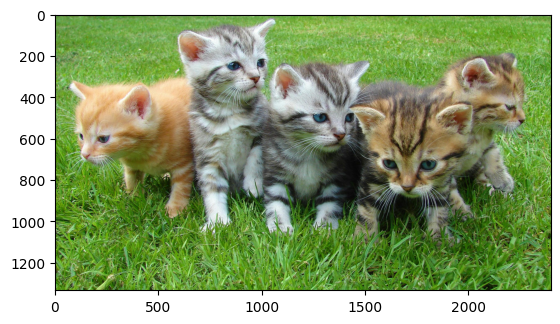

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('/content/image_1.jpg')
plt.imshow(img)

In [35]:
image_classifier = pipeline("image-classification")

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [36]:
image_classifier(img)

[{'label': 'tabby, tabby cat', 'score': 0.37644079327583313},
 {'label': 'Egyptian cat', 'score': 0.3623449504375458},
 {'label': 'tiger cat', 'score': 0.11041756719350815},
 {'label': 'lynx, catamount', 'score': 0.017167888581752777},
 {'label': 'Persian cat', 'score': 0.006183364894241095}]